In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
import gc
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from collections import namedtuple
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import mixture
import seaborn as sns
import numpy as np
from IPython.display import clear_output
device = torch.device("cuda:0")
sns.set_style("darkgrid")

In [3]:
datasets = {}

Data = namedtuple("Data", ['x', 'y'])

data_path_Xi = "data/task1_{i}_learn_X.csv"
data_path_yi = "data/task1_{i}_learn_y.csv"

for i in range(1, 15, 1):
    X = np.array(pd.read_csv(data_path_Xi.format(i=i), delimiter=' ').values)
    y = np.array(pd.read_csv(data_path_yi.format(i=i), delimiter=' ').values.reshape(-1))
    datasets.update({i: Data(X,y)})

In [4]:
pd.DataFrame(datasets[10][1])

,0
0,0.0
1,1.0
2,0.0
3,0.0
4,0.0
...,...
994,1.0
995,0.0
996,1.0
997,1.0


In [5]:
len(datasets[10][0])

999

In [6]:
len(datasets[10][1])

999

In [38]:
 X_train, X_test, y_train, y_test = train_test_split(datasets[10][0], datasets[10][1], test_size=0.1, shuffle=True, stratify = datasets[10][1])

In [ ]:
import numpy as np

from bayesian_dimension_reduction.bfs import (
    train_bfs_model,
    predict_bfs_model,
    get_w_draws_bfs,
)
from bayesian_dimension_reduction.moas import (
    train_moas_model,
    predict_moas_model,
    get_w_draws_moas,
)
from bayesian_dimension_reduction.bgp import (
    train_bgp_model,
    predict_bgp_model,
    get_w_draws_bgp,
)
from bayesian_dimension_reduction.utils import (
    generic_validation_routine,
    load_dataset,
    save_case_results,
)

#####################
# Script Parameters #
#####################

CASE_PARAMETERS = {
    "name": "moas_naca0012_lift_60_training_samples",
    "model_name": "moas",  # one of ['bfs', 'moas', 'bgp']
    "dataset": {
        # name of the csv file containing the observed data
        # (assumed to be in the `data` directory)
        "name": "naca0012",
        "num_inputs": 18,  # the number of inputs is used to parse the csv file
        "num_outputs": 2,  # the number of outputs is used to parse the csv file
        "output_name": "lift",  # the csv column name corresponding to the response
    },
    "num_training_samples": 60,
}

MCMC_PARAMETERS = {
    "target_acceptance_probability": 0.8,
    "num_chains": 1,
    "chain_method": "parallel",
    "num_warmup_draws": 500,
    "num_posterior_draws": 1000,
    "random_seed": 0,
    "progress_bar": True,
    "display_summary": True,
}

PYMANOPT_SOLVER_PARAMS = {
    "maxiter": 5000,
    "minstepsize": 1e-5,
    "mingradnorm": 2e-1,
    "cost_improvement_threshold": 1e-3,
    "no_cost_improvement_streak": 50,
}

PROCESS_PARAMETERS = {
    "training_parameters": {
        "bfs": {"dim_feature_space": 1, "mcmc_params": MCMC_PARAMETERS},
        "moas": {
            "dim_feature_space": 1,
            "num_restarts": 100,
            "random_seed_for_restarts": 0,
            "pymanopt_solver_params": PYMANOPT_SOLVER_PARAMS,
        },
        "bgp": {"dim_feature_space": 1, "mcmc_params": MCMC_PARAMETERS},
    },
    "prediction_parameters": {
        "bfs": {
            "dim_feature_space": 1,
            "num_posterior_draws": 100,
            "num_samples": 10,
            "random_seed": 0,
        },
        "moas": {"num_samples": 10, "random_seed": 0},
        "bgp": {"num_posterior_draws": 100, "num_samples": 10, "random_seed": 0},
    },
    "validation_parameters": {"quantile_values": [0.025, 0.5, 0.975]},
}

#####################
# Main Run Function #
#####################


MODEL_ROUTINES = {
    "bfs": (train_bfs_model, predict_bfs_model, get_w_draws_bfs),
    "moas": (train_moas_model, predict_moas_model, get_w_draws_moas),
    "bgp": (train_bgp_model, predict_bgp_model, get_w_draws_bgp),
}


def run_one_case(process_parameters, case_parameters):
    # Retrieve relevant data
    model_name = case_parameters["model_name"]
    (training_routine, prediction_routine, get_w_draws) = MODEL_ROUTINES[model_name]
    training_parameters = process_parameters["training_parameters"][model_name]
    prediction_parameters = process_parameters["prediction_parameters"][model_name]
    validation_parameters = process_parameters["validation_parameters"]

    # Load dataset and
    x, y, dy_dx = load_dataset(case_parameters["dataset"])

    # Randomly split dataset as training and validation sets
    # based on the desired number of training points
    all_indices = np.arange(x.shape[0])
    training_indices = np.sort(
        np.random.choice(
            all_indices, case_parameters["num_training_samples"], replace=False
        )
    )
    validation_indices = np.setdiff1d(all_indices, training_indices)

    # Prepare training and validation sets
    training_data = {"x": x[training_indices], "y": y[training_indices]}
    validation_data = {"x": x[validation_indices], "y": y[validation_indices]}

    # Train model
    training_artifacts = training_routine(training_data, training_parameters)

    # Validate model
    validation_artifacts = generic_validation_routine(
        training_data,
        training_parameters,
        training_artifacts,
        prediction_routine,
        prediction_parameters,
        validation_data,
        validation_parameters,
        get_w_draws,
        dy_dx,
    )

    # Save results
    save_case_results(case_parameters, training_artifacts, validation_artifacts)


if __name__ == "__main__":
    run_one_case(PROCESS_PARAMETERS, CASE_PARAMETERS)


In [39]:
X_train.shape

(899, 1500)

In [40]:
y_train.shape

(899,)

In [42]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X_train)
X_test_minmax =  min_max_scaler.transform(X_test)

In [43]:
%%time

import umap
manifold = umap.UMAP(n_components=3, metric = "manhattan").fit(X_train, y_train)



CPU times: user 17.4 s, sys: 130 ms, total: 17.5 s
Wall time: 2.45 s


ValueError: X has 1500 features, but MinMaxScaler is expecting 3 features as input.

In [44]:
X_reduced = manifold.transform(X_test)

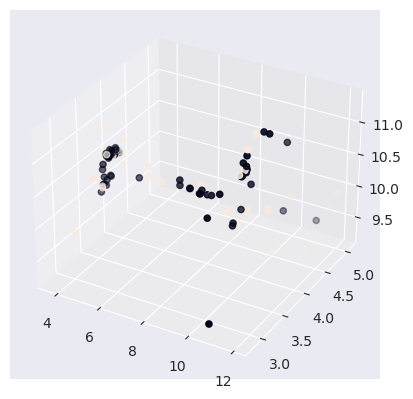

In [45]:
X_reduced = manifold.transform(X_test)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y_test)

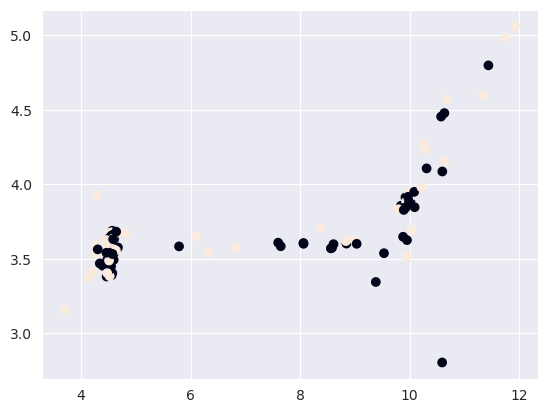

In [46]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_test)


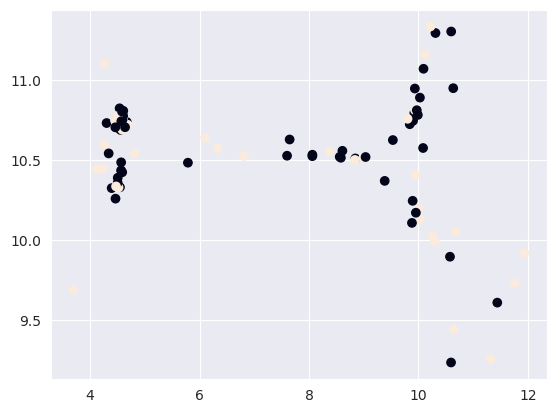

In [47]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(X_reduced[:, 0], X_reduced[:, 2], c=y_test)

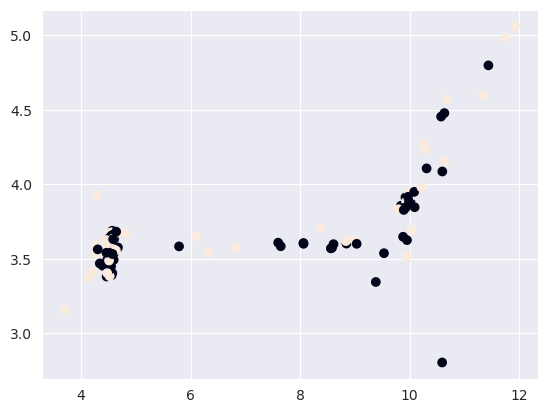

In [49]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_test)

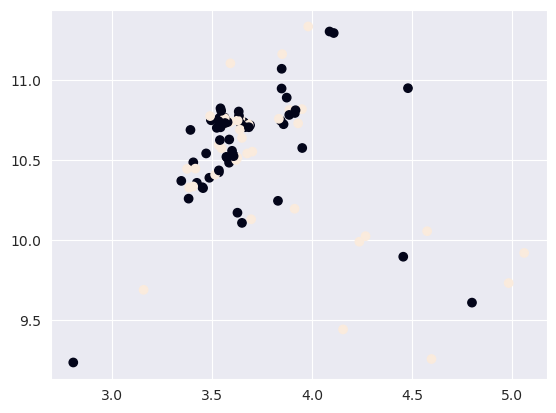

In [50]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(X_reduced[:, 1], X_reduced[:, 2], c=y_test)

In [52]:
discretizer = preprocessing.KBinsDiscretizer(n_bins = 1000, encode='ordinal', strategy='uniform', subsample=None)

In [53]:
discretizer.fit(X_train_minmax)

KBinsDiscretizer(encode='ordinal', n_bins=1000, strategy='uniform',
                 subsample=None)

In [54]:
X_train_minmax

array([[0.46587319, 0.54441568, 0.58235616, ..., 0.4005874 , 0.64513343,
        0.52658361],
       [0.46586966, 0.54441465, 0.58235858, ..., 0.40058785, 0.6451309 ,
        0.52658509],
       [0.46587572, 0.5444162 , 0.58235442, ..., 0.40059   , 0.64513483,
        0.52658215],
       ...,
       [0.46587607, 0.54441616, 0.58235417, ..., 0.40058616, 0.64512821,
        0.52658501],
       [0.46587065, 0.54441521, 0.57940602, ..., 0.40058903, 0.64512981,
        0.52658615],
       [0.46587163, 0.54441662, 0.58235723, ..., 0.40058957, 0.64513496,
        0.52658121]])

In [1061]:
params

array([3., 3., 5., ..., 4., 6., 7.])

In [58]:
from scipy.stats import mode 
def NaiveFit(X):
    return mode(X, axis=0).mode

In [59]:
def NaiveTransform(X, params):
    X_ = []
    for e in X:
        X_.append(1*(e == params))
    return np.array(X_)


In [60]:
params = NaiveFit(discretizer.transform(X_train_minmax))

In [61]:
params

array([465., 544., 582., ..., 400., 645., 526.])

In [92]:
X_train_minmax_tranformed = NaiveTransform(discretizer.transform(X_train_minmax), params)
X_test_minmax_tranformed =  NaiveTransform(discretizer.transform(X_test_minmax), params)

In [119]:
%%time

import umap
manifold = umap.UMAP(n_components=30, metric = "manhattan").fit(X_train_minmax_tranformed, y_train)


CPU times: user 14.8 s, sys: 298 ms, total: 15.1 s
Wall time: 2.31 s


(899, 2)

In [120]:
X_reduced = manifold.transform(X_test_minmax_tranformed)
X_reduced_train = manifold.transform(X_train_minmax_tranformed)

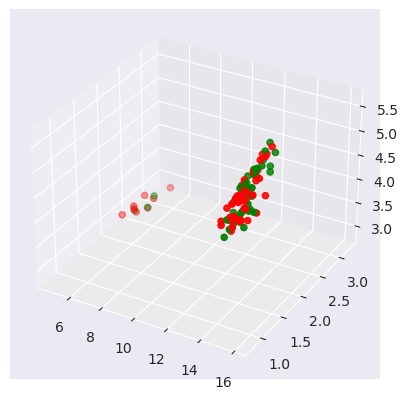

In [121]:

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
color= ['red' if l == 0 else 'green' for l in y_test]
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=color)

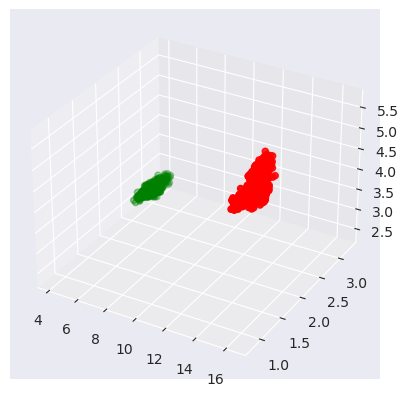

In [122]:

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
color= ['red' if l == 0 else 'green' for l in y_train]
ax.scatter(X_reduced_train[:, 0], X_reduced_train[:, 1], X_reduced_train[:, 2], c=color)

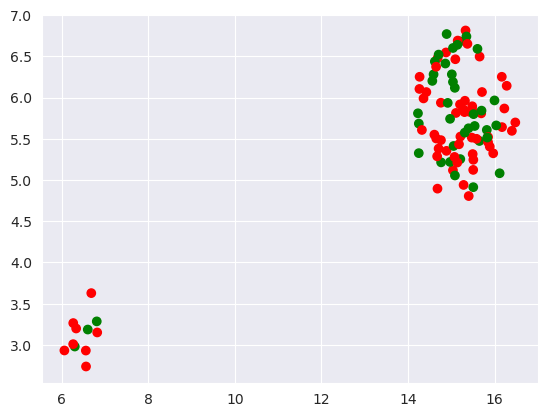

In [77]:
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=color)

In [1067]:
X_train_minmax_tranformed

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [1068]:
from scipy.stats import mode
mode(X_train_minmax_tranformed, axis=0)

ModeResult(mode=array([1, 1, 1, ..., 1, 1, 1]), count=array([877, 877, 869, ..., 866, 871, 873]))

In [731]:
params

array([3., 3., 5., ..., 4., 6., 7.])

In [732]:
X_train_minmax_tranformed.shape

(499, 1500)

In [733]:
y_train.shape

(499,)

In [734]:
import sklearn.naive_bayes
clf = sklearn.naive_bayes.CategoricalNB(fit_prior = 1)
sklearn.model_selection.cross_val_score
clf.fit(X_train_minmax_tranformed, y_train)
print(clf.category_count_)
#cross_val_score(clf, X_train_minmax_tranformed, y = y_train, cv=10, verbose = True)
y_pred_test = clf.predict(X_test_minmax_tranformed)
y_pred_train = clf.predict(X_train_minmax_tranformed)

[array([[  7., 298.],
       [  7., 187.]]), array([[  7., 298.],
       [  8., 186.]]), array([[  8., 297.],
       [  9., 185.]]), array([[  6., 299.],
       [  7., 187.]]), array([[ 16., 289.],
       [  6., 188.]]), array([[  6., 299.],
       [  9., 185.]]), array([[  5., 300.],
       [  8., 186.]]), array([[ 11., 294.],
       [  4., 190.]]), array([[  8., 297.],
       [ 10., 184.]]), array([[  4., 301.],
       [  4., 190.]]), array([[ 11., 294.],
       [  4., 190.]]), array([[  6., 299.],
       [  4., 190.]]), array([[  9., 296.],
       [  4., 190.]]), array([[  5., 300.],
       [  3., 191.]]), array([[  7., 298.],
       [  8., 186.]]), array([[ 17., 288.],
       [  7., 187.]]), array([[  8., 297.],
       [  9., 185.]]), array([[  7., 298.],
       [  8., 186.]]), array([[  8., 297.],
       [  9., 185.]]), array([[ 10., 295.],
       [  9., 185.]]), array([[ 10., 295.],
       [  7., 187.]]), array([[  7., 298.],
       [  5., 189.]]), array([[ 11., 294.],
       [  

/home/sasha/anaconda3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:591: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(


In [735]:
print(y_pred_test)
print(y_test)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.
 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1.
 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.
 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1.

In [736]:
print(y_pred_train)
print(y_train)

[1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0.
 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0.
 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1.
 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0.
 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0.
 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.
 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.

In [737]:
from sklearn.metrics import accuracy_score
accuracy_score(y_pred_test, y_test)


0.568

In [738]:
accuracy_score(y_pred_train, y_train)

0.9599198396793587

In [453]:

def NaiveFit(X):
    return mode(X, axis=0).mode
params = NaiveFit(X_train_minmax_tranformed)

In [526]:
params

array([4., 4., 5., ..., 4., 5., 6.])

In [454]:
def NaiveTransformed(X, params):
    res = []
    for e in X:
        res.append(np.sum(e == params))
    return np.array(res)

/home/sasha/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/sasha/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/sasha/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/sasha/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

<Axes: ylabel='Count'>

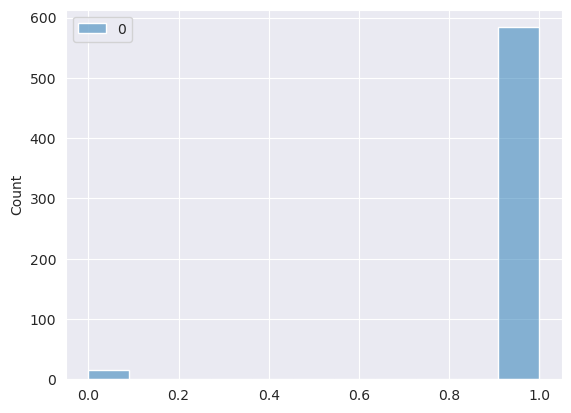

In [689]:

sns.histplot(X_train_minmax_tranformed[:, :1])

In [739]:
def RT_transformed(X):
    rt = []
    for e in X:
        rt.append(np.sum(e))
    rt = np.array(rt)
    return rt

In [740]:
rt = RT_transformed(X_train_minmax_tranformed)


/home/sasha/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/sasha/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/sasha/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/sasha/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

<Axes: ylabel='Probability'>

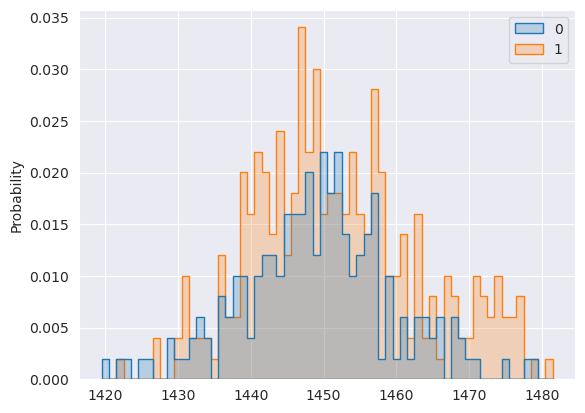

In [741]:
sns.histplot((rt[y_train == 1] , rt[y_train == 0]), discrete = True, stat = "probability", element="step")

/home/sasha/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/sasha/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Probability'>

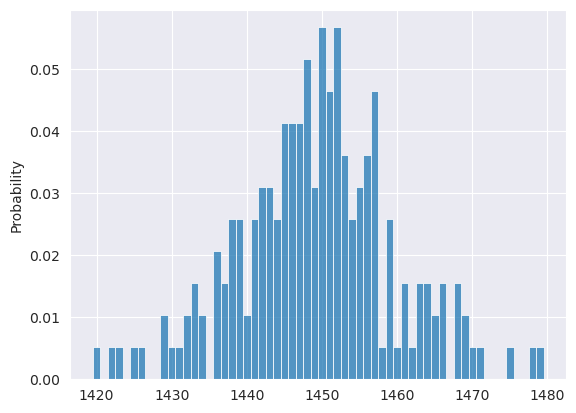

In [742]:
sns.histplot(rt[y_train == 1] , discrete = True, stat = "probability")

/home/sasha/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/sasha/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Probability'>

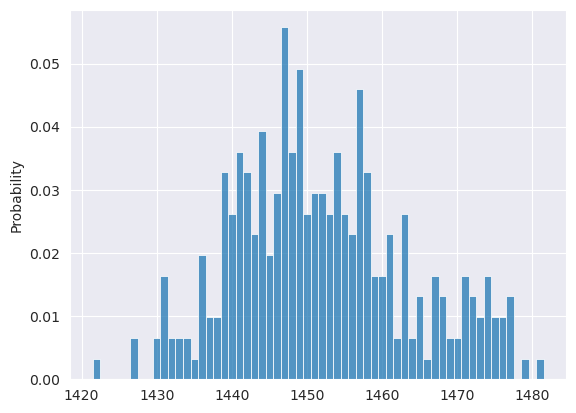

In [743]:
sns.histplot(rt[y_train == 0], discrete = True, stat = "probability")

In [744]:
X_train_minmax_tranformed.shape

(499, 1500)

In [1114]:
conc = np.hstack((X_train_minmax, y_train.reshape(-1, 1)))
data101 = pd.DataFrame(conc)

In [1115]:
corr1 = data101.corrwith(data101[data10.columns[-1]])
corr1

0       0.074672
1      -0.000120
2      -0.029908
3       0.012488
4      -0.015244
          ...   
1496   -0.005876
1497   -0.029050
1498    0.026636
1499    0.008273
1500    1.000000
Length: 1501, dtype: float64

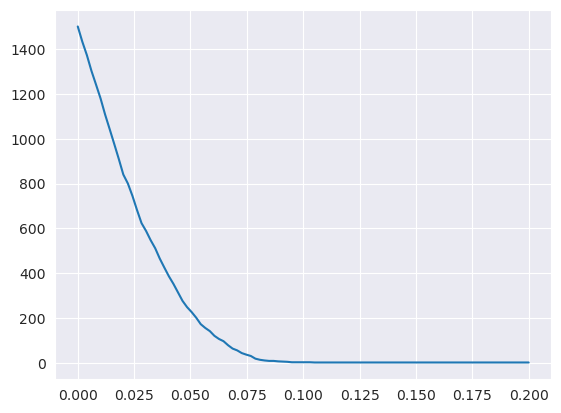

In [1116]:
x = np.linspace(0, 0.2, 100)
y = []
for delta in x:
    y.append(np.sum(np.abs(corr1) > delta))
plt.plot(x, y)
plt.show()

In [129]:
conc = np.hstack((X_train_minmax_tranformed, y_train.reshape(-1, 1)))
data10 = pd.DataFrame(conc)

In [130]:
from sklearn.feature_selection import mutual_info_classif
t = mutual_info_classif(data10.to_numpy(), data10[2])


In [131]:
np.max(t)

0.19595021887490682

In [132]:

corr = mutual_info_classif(data10.to_numpy(), data10[data10.columns[-1]])
corr

array([0.00586536, 0.        , 0.        , ..., 0.        , 0.        ,
       0.66900011])

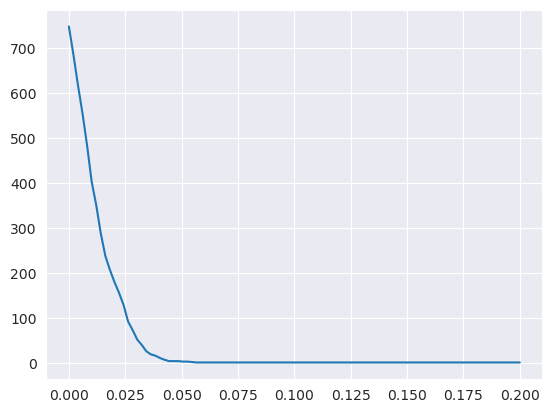

In [1131]:
x = np.linspace(0, 0.2, 100)
y = []
for delta in x:
    y.append(np.sum(np.abs(corr) > delta))
plt.plot(x, y)
plt.show()

In [1072]:
data10 = data10.drop(data10.columns[-1], axis = 1)

In [142]:
data10

,0,1,2,3,4,5,6,7,8,9,...,1491,1492,1493,1494,1495,1496,1497,1498,1499,1500
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
894,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
895,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
896,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
897,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [1135]:
from sklearn.feature_selection import mutual_info_classif as mi_class
def custom_mi_reg(a, b):
    a = a.reshape(-1, 1)
    b = b.reshape(-1, 1)
    return  mi_class(a, b)[0]
cor_matrix = data10.corr(method=custom_mi_reg)

/home/sasha/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.

In [1075]:
cor_matrix

,0,1,2,3,4,5,6,7,8,9,...,1490,1491,1492,1493,1494,1495,1496,1497,1498,1499
0,1.000000,0.021509,0.010657,0.018431,0.009524,0.029932,0.028917,0.014310,0.007367,0.073736,...,0.016998,0.023891,0.030428,0.013046,0.107755,0.015626,0.077809,0.030918,0.028398,0.015626
1,0.021509,1.000000,0.090826,0.026231,0.009524,0.029932,0.011830,0.056490,0.030918,0.024923,...,0.016998,0.122549,0.008428,0.054490,0.018431,0.058585,0.032349,0.030918,0.013046,0.058585
2,0.010657,0.090826,1.000000,0.030772,0.032772,0.001170,0.001131,0.039879,0.036270,0.055960,...,0.081577,0.028027,0.031159,0.037993,0.046072,0.004892,0.006360,0.003334,0.002340,0.032065
3,0.018431,0.026231,0.030772,1.000000,0.006521,0.044339,0.008819,0.029142,0.041065,0.024982,...,0.028010,0.021807,0.042672,0.049755,0.015381,0.012596,0.036566,0.004368,0.029694,0.028581
4,0.009524,0.009524,0.032772,0.006521,1.000000,0.031106,0.034503,0.038181,0.004472,0.054162,...,0.042190,0.028506,0.029499,0.001210,0.031298,0.040140,0.038598,0.004472,0.001210,0.003763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0.015626,0.058585,0.004892,0.012596,0.040140,0.003763,0.031508,0.008522,0.072206,0.018973,...,0.011181,0.018973,0.038495,0.007268,0.012596,1.000000,0.035247,0.036908,0.045478,0.029782
1496,0.077809,0.032349,0.006360,0.036566,0.038598,0.023588,0.005179,0.035939,0.039870,0.030808,...,0.034466,0.030808,0.083245,0.028700,0.001370,0.035247,1.000000,0.020472,0.036620,0.001393
1497,0.030918,0.030918,0.003334,0.004368,0.004472,0.004472,0.031320,0.000308,0.024809,0.029445,...,0.033015,0.010663,0.090206,0.000947,0.004368,0.036908,0.020472,1.000000,0.033106,0.001610
1498,0.028398,0.013046,0.002340,0.029694,0.001210,0.036304,0.032735,0.031550,0.067159,0.027045,...,0.008621,0.059789,0.069237,0.004715,0.010031,0.045478,0.036620,0.033106,1.000000,0.030942


In [1076]:
np.min(data10.values)

0.0

In [1084]:
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))

In [1085]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > delta_)] 
print(to_drop)

[430, 475, 560, 679, 701, 746, 761, 808, 815, 838, 882, 887, 915, 928, 956, 964, 966, 985, 1000, 1003, 1021, 1036, 1040, 1048, 1051, 1067, 1070, 1086, 1087, 1142, 1165, 1168, 1186, 1190, 1216, 1223, 1242, 1247, 1254, 1276, 1327, 1331, 1338, 1343, 1383, 1388, 1391, 1408, 1477, 1479, 1488, 1497, 1499]


In [128]:
data102 = data10.drop(data10[to_drop], axis = 1)

NameError: name 'data10' is not defined

In [1087]:
data102

,0,1,2,3,4,5,6,7,8,9,...,1487,1489,1490,1491,1492,1493,1494,1495,1496,1498
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
894,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
895,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
896,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
897,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [1088]:
y_train

array([0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0.,
       1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0.,
       1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       0., 0., 1., 1., 1.

In [1089]:

data102["target"] = y_train

In [1090]:
data102

,0,1,2,3,4,5,6,7,8,9,...,1489,1490,1491,1492,1493,1494,1495,1496,1498,target
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
894,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
895,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
896,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
897,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [127]:
corr = data102.corrwith(data102[data102.columns[-1]])
corr

NameError: name 'data102' is not defined

0.05
3


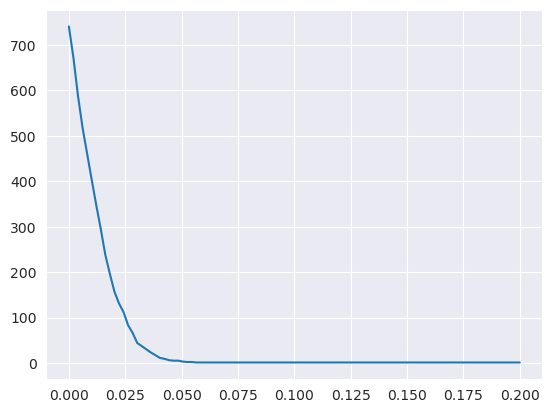

In [135]:
x = np.linspace(0, 0.2, 100)
y = []
for deltai in x:
    y.append(np.sum(np.abs(corr) > deltai))
print(delta)
print(np.sum(np.abs(corr) > 0.05))
plt.plot(x, y)
plt.show()

In [173]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
selection = SelectKBest(chi2, k=20)
selection.fit(X_train_minmax_tranformed, y_train)
X_new.shape

(899, 2)

In [174]:
delta = 0.05
delta_ = 0.05

In [175]:

X_train_sparced = selection.transform(X_train_minmax_tranformed)
X_test_sparced = selection.transform(X_test_minmax_tranformed)

In [178]:

print(np.sum(np.abs(corr[:-1]) > delta))

corr = np.corrcoef(X_train_sparced, y_train)
print(corr)
print(np.sum(np.abs(corr[:-1]) > delta))
X_train_sparced = X_train_sparced[:,np.abs(corr[:-1]) > delta]
X_test_sparced = X_test_sparced[:,np.abs(corr[:-1]) > delta]
print(X_train_sparced.shape)


0


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 20 and the array at index 1 has size 899

In [1094]:
X_train_sparced

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [1095]:
X_train_sparced

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [1096]:
X_test_sparced

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 0]])

In [1097]:
import sklearn.naive_bayes
clf = sklearn.naive_bayes.BernoulliNB(fit_prior = 1)
sklearn.model_selection.cross_val_score
clf.fit(X_train_sparced, y_train)
print(np.sum(clf.class_count_))
print(clf.feature_count_)
print(clf.feature_count_ / np.sum(clf.class_count_))
#cross_val_score(clf, X_train_minmax_tranformed, y = y_train, cv=10, verbose = True)
y_pred_test = clf.predict(X_test_sparced)
y_pred_train = clf.predict(X_train_sparced)

899.0
[[533. 526. 524. 531. 533. 516. 532. 524. 524. 530. 528. 532. 526. 528.
  537. 530. 528. 531. 539. 528. 529. 533. 526. 541. 528. 535. 540. 541.
  526. 534. 520. 529. 527. 537. 531. 542. 527. 538. 526. 542. 527. 520.
  519. 537. 536. 539. 532. 528. 538. 529. 540. 533. 532. 533. 539. 528.
  530. 535. 525. 538. 544. 528. 539. 538. 540. 538. 524. 529. 525. 542.
  538. 534. 537. 541. 536. 532. 538. 538. 534. 536. 528. 545. 528. 532.
  535. 526. 528. 533. 523. 536. 531. 538. 535. 533. 539. 534. 539. 529.
  536. 526. 535. 536. 544. 537. 541. 529. 535. 541. 539. 526. 538. 538.
  523. 539. 526. 532. 536. 538. 524. 526. 538. 526. 536. 528. 522. 532.
  535. 534. 537. 541. 541. 532. 534. 543. 539. 535. 534. 530. 540. 527.
  542. 542. 540. 526. 539. 536. 526. 538. 544. 531. 522. 532. 537. 531.
  529. 536. 540. 524. 527. 534. 531. 532. 537. 533. 526. 524. 537. 530.
  541. 526. 534. 523. 532. 541. 525. 541. 532. 537. 540. 543. 537. 538.
  539. 527. 527. 532. 523. 537. 525. 526. 530.]
 [333. 344

/home/sasha/anaconda3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:591: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(


In [1098]:
clf.fit(X_test_sparced, y_test)
print(clf.class_count_.reshape(-1, 1))
q = np.divide(clf.feature_count_,  clf.class_count_.reshape(-1, 1))
q

[[61.]
 [39.]]


/home/sasha/anaconda3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:591: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(


array([[0.93442623, 0.96721311, 0.98360656, 0.95081967, 1.        ,
        0.96721311, 0.96721311, 0.95081967, 0.95081967, 0.98360656,
        0.98360656, 0.96721311, 0.96721311, 0.95081967, 0.98360656,
        0.98360656, 0.98360656, 0.93442623, 0.93442623, 0.95081967,
        0.96721311, 0.96721311, 0.98360656, 0.96721311, 0.98360656,
        0.98360656, 0.98360656, 0.98360656, 0.96721311, 0.96721311,
        0.98360656, 1.        , 0.93442623, 0.98360656, 0.93442623,
        0.96721311, 1.        , 0.98360656, 1.        , 1.        ,
        0.95081967, 0.98360656, 0.95081967, 0.93442623, 0.96721311,
        1.        , 0.98360656, 0.93442623, 0.93442623, 1.        ,
        0.98360656, 0.93442623, 1.        , 1.        , 1.        ,
        1.        , 0.96721311, 0.93442623, 0.98360656, 0.95081967,
        1.        , 1.        , 0.98360656, 0.96721311, 1.        ,
        0.96721311, 0.95081967, 0.95081967, 0.98360656, 0.98360656,
        0.96721311, 0.98360656, 0.98360656, 0.95

In [1099]:
clf.fit(X_train_sparced, y_train)
print(clf.class_count_.reshape(-1, 1))
q = np.divide(clf.feature_count_,  clf.class_count_.reshape(-1, 1))
q

[[549.]
 [350.]]


/home/sasha/anaconda3/lib/python3.11/site-packages/sklearn/utils/_param_validation.py:591: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(


array([[0.9708561 , 0.95810565, 0.95446266, 0.96721311, 0.9708561 ,
        0.93989071, 0.96903461, 0.95446266, 0.95446266, 0.96539162,
        0.96174863, 0.96903461, 0.95810565, 0.96174863, 0.97814208,
        0.96539162, 0.96174863, 0.96721311, 0.98178506, 0.96174863,
        0.96357013, 0.9708561 , 0.95810565, 0.98542805, 0.96174863,
        0.97449909, 0.98360656, 0.98542805, 0.95810565, 0.9726776 ,
        0.94717668, 0.96357013, 0.95992714, 0.97814208, 0.96721311,
        0.98724954, 0.95992714, 0.97996357, 0.95810565, 0.98724954,
        0.95992714, 0.94717668, 0.94535519, 0.97814208, 0.97632058,
        0.98178506, 0.96903461, 0.96174863, 0.97996357, 0.96357013,
        0.98360656, 0.9708561 , 0.96903461, 0.9708561 , 0.98178506,
        0.96174863, 0.96539162, 0.97449909, 0.95628415, 0.97996357,
        0.99089253, 0.96174863, 0.98178506, 0.97996357, 0.98360656,
        0.97996357, 0.95446266, 0.96357013, 0.95628415, 0.98724954,
        0.97996357, 0.9726776 , 0.97814208, 0.98

In [1100]:
accuracy_score(y_pred_test, y_test)

0.6

In [1101]:
accuracy_score(y_pred_train, y_train)

0.8320355951056729

In [563]:
res = NaiveTransformed(X_train_minmax_tranformed, params)

np.sum(y_train == res)


366

In [96]:
y = datasets[10][1]
y.shape

(999,)

/home/sasha/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/sasha/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

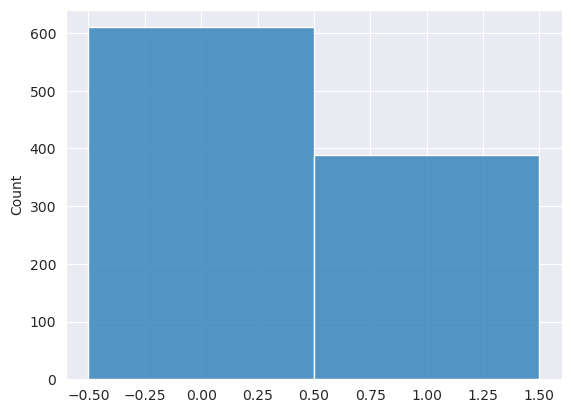

In [97]:
sns.histplot(y, discrete = True)

In [ ]:
sns.histplot(X_train_minmax_tranformed[y==0], discrete = True)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

In [4]:
X_trains = [None]
X_tests = [None]
y_trains = [None]
y_tests = [None]

for i in range(1, 15, 1):

    X, y = datasets[i]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, 
                     shuffle=True, stratify=y)
    X_trains.append(X_train)
    X_tests.append(X_test)
    y_trains.append(y_train)
    y_tests.append(y_test)

In [11]:
datasets[1].shape


AttributeError: 'Data' object has no attribute 'shape'

In [5]:
def corr(x, y):
    numerator = ((x - x.mean(axis=-1, keepdims=True))*(y - y.mean(axis=-1, keepdims=True))).sum(axis=-1)
    denominator = (np.sum((x - x.mean(axis=-1, keepdims=True))**2, axis=-1) * np.sum((y - y.mean(axis=-1, keepdims=True))**2, axis=-1)) ** 0.5
    return numerator / denominator

from copy import deepcopy
features_correlations = []

for i in tqdm(range(1, 15, 1), colour="#229922"):

    X, y = datasets[i]
    X = X.T
    features_count = X.shape[0]

    corr_matrix = np.zeros((features_count, features_count))
    
    for i in tqdm(range(features_count), colour="#222299", leave=False):
        corr_matrix[i] = corr(X, X[0])
    features_correlations.append(deepcopy(corr_matrix))

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [10]:
for i in range(1, 15, 1):
    print(f"Dataset {i}")
    print(f" {np.sum(np.abs(features_correlations[i-1]) > 0.3) - features_correlations[i-1].shape[0]}")

Dataset 1
 0
Dataset 2
 0
Dataset 3
 0
Dataset 4
 450
Dataset 5
 0
Dataset 6
 39800
Dataset 7
 0
Dataset 8
 3000
Dataset 9
 1500
Dataset 10
 0
Dataset 11
 0
Dataset 12
 0
Dataset 13
 10
Dataset 14
 0


In [11]:
class ASY:
    def __init__(self, P) -> None:
        self.P = P
        self.__name__ = self.__class__.__name__ + f'_{P}'
    def __call__(self, y_pred, y_true) -> float:
        return np.mean(self.P[np.round(y_true, 0).astype(int), np.round(y_pred, 0).astype(int)])

In [21]:
from sklearn import naive_bayes
from collections import namedtuple

ASY1 = ASY(np.array([[-9, 9], [1, 0]]))
ASY2 = ASY(np.array([[-1, 3], [2, -1]]))

Res = namedtuple("Results", ("ones_prop", "train_acc", "test_acc", "var_smoothing"))
Res_auc = namedtuple("Results", ("ones_prop", "train_AUC", "test_AUC", "var_smoothing"))
Res_ASY1 = namedtuple("Results", ("ones_prop", "train_ASY1", "test_ASY1", "var_smoothing"))
Res_ASY2 = namedtuple("Results", ("ones_prop", "train_ASY2", "test_ASY2", "var_smoothing"))

# results_naive_bayes = {}
# results_naive_bayes_AUC = {}
# results_naive_bayes_ASY1 = {}
# results_naive_bayes_ASY2 = {}


var_smoothings = np.logspace(start=-5, stop=2, num=1000)

for i in tqdm(range(1, 15, 1), colour="#229922"):
    X_train, X_test, y_train, y_test = X_trains[i], X_tests[i], y_trains[i], y_tests[i]
    
    for var_smoothing in tqdm(var_smoothings, colour="#222299"):

        clf = naive_bayes.GaussianNB(var_smoothing=var_smoothing).fit(X_train, y_train)
        y_pred_train = clf.predict_proba(X_train)[:, 1]
        y_pred_test = clf.predict_proba(X_test)[:, 1]

        ones_prop = (y_train.sum() + y_test.sum()) / (len(y_train)+len(y_test))
        test_acc = sum(np.round(y_pred_test, 0) == y_test) / len(y_test)
        train_acc = sum(np.round(y_pred_train, 0) == y_train) / len(y_train)
        try:
            test_auc = sklearn.metrics.roc_auc_score(y_test, y_pred_test)
        except: test_auc = 0
        try:
            train_auc = sklearn.metrics.roc_auc_score(y_train, y_pred_train)
        except: train_auc = 0
        train_ASY1 = ASY1(y_pred_train, y_train)
        test_ASY1 = ASY1(y_pred_test, y_test)
        train_ASY2 = ASY2(y_pred_train, y_train)
        test_ASY2 = ASY2(y_pred_test, y_test)
        
    
        results = Res(ones_prop, train_acc, test_acc, var_smoothing)
        results_auc = Res_auc(ones_prop, train_auc, test_auc, var_smoothing)
        results_ASY1 = Res_ASY1(ones_prop, train_ASY1, test_ASY1, var_smoothing)
        results_ASY2 = Res_ASY2(ones_prop, train_ASY2, test_ASY2, var_smoothing)
        
        prev_res = results_naive_bayes.get(i)
        if prev_res is None or prev_res.test_acc < results.test_acc:
            results_naive_bayes.update({i:results})    

        prev_res_auc = results_naive_bayes_AUC.get(i)
        if prev_res_auc is None or prev_res_auc.test_AUC < results_auc.test_AUC:
            results_naive_bayes_AUC.update({i:results_auc}) 

        prev_res_ASY1 = results_naive_bayes_ASY1.get(i)
        if prev_res_ASY1 is None or prev_res_ASY1.test_ASY1 > results_ASY1.test_ASY1:
            results_naive_bayes_ASY1.update({i:results_ASY1}) 

        prev_res_ASY2 = results_naive_bayes_ASY2.get(i)
        if prev_res_ASY2 is None or prev_res_ASY2.test_ASY2 > results_ASY2.test_ASY2:
            results_naive_bayes_ASY2.update({i:results_ASY2}) 

    print(f"Dataset {i}\n  Var_smoothing: {results_naive_bayes[i].var_smoothing}\n  Ones proportion: {results_naive_bayes[i].ones_prop}\n  Train acc: {results_naive_bayes[i].train_acc}\n  Test acc: {results_naive_bayes[i].test_acc}\n")
    print(f"\n  Var_smoothing: {results_naive_bayes_AUC[i].var_smoothing}\n  Ones proportion: {results_naive_bayes_AUC[i].ones_prop}\n  Train AUC: {results_naive_bayes_AUC[i].train_AUC}\n  Test AUC: {results_naive_bayes_AUC[i].test_AUC}\n")
    print(f"\n  Var_smoothing: {results_naive_bayes_ASY1[i].var_smoothing}\n  Ones proportion: {results_naive_bayes_ASY1[i].ones_prop}\n  Train ASY1: {results_naive_bayes_ASY1[i].train_ASY1}\n  Test ASY1: {results_naive_bayes_ASY1[i].test_ASY1}\n")
    print(f"\n  Var_smoothing: {results_naive_bayes_ASY2[i].var_smoothing}\n  Ones proportion: {results_naive_bayes_ASY2[i].ones_prop}\n  Train ASY2: {results_naive_bayes_ASY2[i].train_ASY2}\n  Test ASY2: {results_naive_bayes_ASY2[i].test_ASY2}\n")

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Dataset 1
  Var_smoothing: 1.1273325637104872
  Ones proportion: 0.5095095095095095
  Train acc: 0.5806451612903226
  Test acc: 0.61


  Var_smoothing: 60.64329395408062
  Ones proportion: 0.5095095095095095
  Train AUC: 0.5851330342908634
  Test AUC: 0.5902360944377751


  Var_smoothing: 0.24739641008868116
  Ones proportion: 0.5095095095095095
  Train ASY1: 0.008898776418242492
  Test ASY1: -0.74


  Var_smoothing: 0.5281079711934331
  Ones proportion: 0.5095095095095095
  Train ASY2: 0.4649610678531702
  Test ASY2: 0.41



  0%|          | 0/1000 [00:00<?, ?it/s]

Dataset 2
  Var_smoothing: 0.3763358362286533
  Ones proportion: 0.4694694694694695
  Train acc: 0.7018909899888766
  Test acc: 0.68


  Var_smoothing: 1e-05
  Ones proportion: 0.4694694694694695
  Train AUC: 0.737990203384105
  Test AUC: 0.7346447209955841


  Var_smoothing: 8.748668120479914
  Ones proportion: 0.4694694694694695
  Train ASY1: -4.10567296996663
  Test ASY1: -4.33


  Var_smoothing: 4.165044248545185
  Ones proportion: 0.4694694694694695
  Train ASY2: 0.19688542825361513
  Test ASY2: 0.05



  0%|          | 0/1000 [00:00<?, ?it/s]

Dataset 3
  Var_smoothing: 0.008911482322840203
  Ones proportion: 0.4874874874874875
  Train acc: 0.5906562847608454
  Test acc: 0.54


  Var_smoothing: 38.59993617679771
  Ones proportion: 0.4874874874874875
  Train AUC: 0.5523727453718836
  Test AUC: 0.5374149659863946


  Var_smoothing: 3.4319071974590427
  Ones proportion: 0.4874874874874875
  Train ASY1: -3.9977753058954395
  Test ASY1: -4.1


  Var_smoothing: 3.4319071974590427
  Ones proportion: 0.4874874874874875
  Train ASY2: 0.46273637374860954
  Test ASY2: 0.47



  0%|          | 0/1000 [00:00<?, ?it/s]

Dataset 4
  Var_smoothing: 0.4422273980505897
  Ones proportion: 0.16416416416416416
  Train acc: 0.8231368186874305
  Test acc: 0.84


  Var_smoothing: 63.65079081295565
  Ones proportion: 0.16416416416416416
  Train AUC: 0.5778511534170656
  Test AUC: 0.5297619047619049


  Var_smoothing: 0.8431909292866251
  Ones proportion: 0.16416416416416416
  Train ASY1: -7.256952169076752
  Test ASY1: -7.4


  Var_smoothing: 0.8431909292866251
  Ones proportion: 0.16416416416416416
  Train ASY2: -0.4938820912124583
  Test ASY2: -0.52



  0%|          | 0/1000 [00:00<?, ?it/s]

Dataset 5
  Var_smoothing: 3.9682461045694777
  Ones proportion: 0.37237237237237236
  Train acc: 0.9299221357063404
  Test acc: 0.63


  Var_smoothing: 1.0327947319189525e-05
  Ones proportion: 0.37237237237237236
  Train AUC: 1.0
  Test AUC: 0.5465465465465467


  Var_smoothing: 5.305480525369574
  Ones proportion: 0.37237237237237236
  Train ASY1: -5.515016685205784
  Test ASY1: -5.3


  Var_smoothing: 5.305480525369574
  Ones proportion: 0.37237237237237236
  Train ASY2: -0.6062291434927698
  Test ASY2: 0.11



  0%|          | 0/1000 [00:00<?, ?it/s]

Dataset 6
  Var_smoothing: 0.00026026478819690045
  Ones proportion: 0.4854854854854855
  Train acc: 0.6729699666295884
  Test acc: 0.71


  Var_smoothing: 0.49510201595563513
  Ones proportion: 0.4854854854854855
  Train AUC: 0.753031684070779
  Test AUC: 0.8119247699079633


  Var_smoothing: 77.248114514034
  Ones proportion: 0.4854854854854855
  Train ASY1: -2.067853170189099
  Test ASY1: -2.77


  Var_smoothing: 77.248114514034
  Ones proportion: 0.4854854854854855
  Train ASY2: 0.08342602892102335
  Test ASY2: -0.04



  0%|          | 0/1000 [00:00<?, ?it/s]

Dataset 7
  Var_smoothing: 2.445616683452444
  Ones proportion: 0.13213213213213212
  Train acc: 0.8620689655172413
  Test acc: 0.87


  Var_smoothing: 27.954159990678594
  Ones proportion: 0.13213213213213212
  Train AUC: 0.5841198017668606
  Test AUC: 0.5481874447391689


  Var_smoothing: 2.445616683452444
  Ones proportion: 0.13213213213213212
  Train ASY1: -7.462736373748609
  Test ASY1: -7.7


  Var_smoothing: 2.445616683452444
  Ones proportion: 0.13213213213213212
  Train ASY2: -0.5739710789766407
  Test ASY2: -0.61



  0%|          | 0/1000 [00:00<?, ?it/s]

Dataset 8
  Var_smoothing: 2.406475150015422
  Ones proportion: 0.2022022022022022
  Train acc: 0.8420467185761957
  Test acc: 0.8


  Var_smoothing: 33.92583382740992
  Ones proportion: 0.2022022022022022
  Train AUC: 0.9351541067022238
  Test AUC: 0.57125


  Var_smoothing: 2.7380251779278577
  Ones proportion: 0.2022022022022022
  Train ASY1: -6.862068965517241
  Test ASY1: -7.0


  Var_smoothing: 2.7380251779278577
  Ones proportion: 0.2022022022022022
  Train ASY2: -0.4972191323692992
  Test ASY2: -0.4



  0%|          | 0/1000 [00:00<?, ?it/s]

Dataset 9
  Var_smoothing: 0.7292272058728313
  Ones proportion: 0.18018018018018017
  Train acc: 0.8509454949944383
  Test acc: 0.84


  Var_smoothing: 2.0479120966650832
  Ones proportion: 0.18018018018018017
  Train AUC: 0.8620198669949914
  Test AUC: 0.5298102981029811


  Var_smoothing: 0.9440064789417604
  Ones proportion: 0.18018018018018017
  Train ASY1: -6.681868743047831
  Test ASY1: -7.21


  Var_smoothing: 0.7292272058728313
  Ones proportion: 0.18018018018018017
  Train ASY2: -0.5105672969966629
  Test ASY2: -0.51



  0%|          | 0/1000 [00:00<?, ?it/s]

Dataset 10
  Var_smoothing: 9.954008287621518
  Ones proportion: 0.3893893893893894
  Train acc: 0.6162402669632926
  Test acc: 0.61


  Var_smoothing: 0.00018249932448161524
  Ones proportion: 0.3893893893893894
  Train AUC: 0.9471168358053604
  Test AUC: 0.4451450189155107


  Var_smoothing: 9.954008287621518
  Ones proportion: 0.3893893893893894
  Train ASY1: -5.112347052280311
  Test ASY1: -5.1


  Var_smoothing: 9.954008287621518
  Ones proportion: 0.3893893893893894
  Train ASY2: 0.15127919911012236
  Test ASY2: 0.17



  0%|          | 0/1000 [00:00<?, ?it/s]

Dataset 11
  Var_smoothing: 0.05172657387216019
  Ones proportion: 0.2182182182182182
  Train acc: 0.8943270300333704
  Test acc: 0.91


  Var_smoothing: 1e-05
  Ones proportion: 0.2182182182182182
  Train AUC: 0.9264159433332366
  Test AUC: 0.956876456876457


  Var_smoothing: 2.1150728248687947
  Ones proportion: 0.2182182182182182
  Train ASY1: -6.810901001112347
  Test ASY1: -6.81


  Var_smoothing: 0.05172657387216019
  Ones proportion: 0.2182182182182182
  Train ASY2: -0.6551724137931034
  Test ASY2: -0.71



  0%|          | 0/1000 [00:00<?, ?it/s]

Dataset 12
  Var_smoothing: 0.0939664831495469
  Ones proportion: 0.36436436436436437
  Train acc: 0.8843159065628476
  Test acc: 0.77


  Var_smoothing: 0.007959777002314986
  Ones proportion: 0.36436436436436437
  Train AUC: 0.948950279783008
  Test AUC: 0.7986111111111112


  Var_smoothing: 9.33189771573324
  Ones proportion: 0.36436436436436437
  Train ASY1: -5.3437152391546165
  Test ASY1: -5.4


  Var_smoothing: 0.0939664831495469
  Ones proportion: 0.36436436436436437
  Train ASY2: -0.5739710789766407
  Test ASY2: -0.18



  0%|          | 0/1000 [00:00<?, ?it/s]

Dataset 13
  Var_smoothing: 0.02029118018046678
  Ones proportion: 0.17917917917917917
  Train acc: 0.8175750834260289
  Test acc: 0.83


  Var_smoothing: 21.945290862033115
  Ones proportion: 0.17917917917917917
  Train AUC: 0.5328653907657088
  Test AUC: 0.5291327913279132


  Var_smoothing: 0.02029118018046678
  Ones proportion: 0.17917917917917917
  Train ASY1: -7.149054505005561
  Test ASY1: -7.21


  Var_smoothing: 0.02029118018046678
  Ones proportion: 0.17917917917917917
  Train ASY2: -0.44938820912124583
  Test ASY2: -0.49



  0%|          | 0/1000 [00:00<?, ?it/s]

Dataset 14
  Var_smoothing: 0.03345989120549975
  Ones proportion: 0.2083906946356488
  Train acc: 0.8361586524394535
  Test acc: 0.8369


  Var_smoothing: 1.556654359271062
  Ones proportion: 0.2083906946356488
  Train AUC: 0.846705069797385
  Test AUC: 0.8462952491887791


  Var_smoothing: 1.183240627458378
  Ones proportion: 0.2083906946356488
  Train ASY1: -6.916462653565383
  Test ASY1: -6.9183


  Var_smoothing: 0.14065272421052363
  Ones proportion: 0.2083906946356488
  Train ASY2: -0.4789276997322212
  Test ASY2: -0.48306666666666664



In [22]:
indexes = [f"Dataset {i}" for i in range(1,15)]
Baseline = [round(max(results_naive_bayes[i].ones_prop, 1-results_naive_bayes[i].ones_prop), 3) for i in range(1,15,1)]
Test_acc = [round(results_naive_bayes[i].test_acc, 3) for i in range(1, 15, 1)]
Test_AUC = [round(results_naive_bayes_AUC[i].test_AUC, 3) for i in range(1, 15, 1)]
Test_ASY1 = [round(results_naive_bayes_ASY1[i].test_ASY1, 3) for i in range(1, 15, 1)]
Test_ASY2 = [round(results_naive_bayes_ASY2[i].test_ASY2, 3) for i in range(1, 15, 1)]

var_smoothing = [(round(results_naive_bayes[i].var_smoothing, 5), 
                  round(results_naive_bayes_AUC[i].var_smoothing, 5),
                  round(results_naive_bayes_ASY1[i].var_smoothing, 5),
                  round(results_naive_bayes_ASY2[i].var_smoothing, 5)) for i in range(1, 15)]

naive_bayes_df = pd.DataFrame(data={"Baseline": Baseline, "Test_acc": Test_acc, 
                                    "Test_AUC": Test_AUC, "Test_ASY1": Test_ASY1, 
                                    "Test_ASY2": Test_ASY2, "Var_smoothing": var_smoothing}, index=indexes)
naive_bayes_df

,Baseline,Test_acc,Test_AUC,Test_ASY1,Test_ASY2,Var_smoothing
Dataset 1,0.510,0.610,0.590,-0.740,0.410,"(1.12733, 60.64329, 0.2474, 0.52811)"
Dataset 2,0.531,0.680,0.735,-4.330,0.050,"(0.37634, 1e-05, 8.74867, 4.16504)"
Dataset 3,0.513,0.540,0.537,-4.100,0.470,"(0.00891, 38.59994, 3.43191, 3.43191)"
Dataset 4,0.836,0.840,0.530,-7.400,-0.520,"(0.44223, 63.65079, 0.84319, 0.84319)"
Dataset 5,0.628,0.630,0.547,-5.300,0.110,"(3.96825, 1e-05, 5.30548, 5.30548)"
Dataset 6,0.515,0.710,0.812,-2.770,-0.040,"(0.00026, 0.4951, 77.24811, 77.24811)"
Dataset 7,0.868,0.870,0.548,-7.700,-0.610,"(2.44562, 27.95416, 2.44562, 2.44562)"
Dataset 8,0.798,0.800,0.571,-7.000,-0.400,"(2.40648, 33.92583, 2.73803, 2.73803)"
Dataset 9,0.820,0.840,0.530,-7.210,-0.510,"(0.72923, 2.04791, 0.94401, 0.72923)"
Dataset 10,0.611,0.610,0.445,-5.100,0.170,"(9.95401, 0.00018, 9.95401, 9.95401)"


In [24]:
from sklearn import discriminant_analysis

Res_QDA_acc = namedtuple("Results", ("ones_prop", "train_acc", "test_acc", "reg_param"))
Res_QDA_auc = namedtuple("Results", ("ones_prop", "train_AUC", "test_AUC", "reg_param"))
Res_QDA_ASY1 = namedtuple("Results", ("ones_prop", "train_ASY1", "test_ASY1", "reg_param"))
Res_QDA_ASY2 = namedtuple("Results", ("ones_prop", "train_ASY2", "test_ASY2", "reg_param"))

# results_QDA_ACC = {}
# results_QDA_AUC = {}
# results_QDA_ASY1 = {}
# results_QDA_ASY2 = {}

reg_params = np.logspace(start=-9, stop=0, num=100)

for i in tqdm(range(1, 15, 1), colour="#229922"):
    X_train, X_test, y_train, y_test = X_trains[i], X_tests[i], y_trains[i], y_tests[i]
    
    for reg_param in tqdm(reg_params, colour="#222299"):

        clf = discriminant_analysis.QuadraticDiscriminantAnalysis(reg_param=reg_param).fit(X_train, y_train)
        y_pred_train = clf.predict_proba(X_train)[:, 1]
        y_pred_test = clf.predict_proba(X_test)[:, 1]

        ones_prop = (y_train.sum() + y_test.sum()) / (len(y_train)+len(y_test))
        test_acc = sum(np.round(y_pred_test, 0) == y_test) / len(y_test)
        train_acc = sum(np.round(y_pred_train, 0) == y_train) / len(y_train)
        try:
            test_auc = sklearn.metrics.roc_auc_score(y_test, y_pred_test)
        except: test_auc = 0
        try:
            train_auc = sklearn.metrics.roc_auc_score(y_train, y_pred_train)
        except: train_auc = 0
        train_ASY1 = ASY1(y_pred_train, y_train)
        test_ASY1 = ASY1(y_pred_test, y_test)
        train_ASY2 = ASY2(y_pred_train, y_train)
        test_ASY2 = ASY2(y_pred_test, y_test)
        
    
        results = Res_QDA_acc(ones_prop, train_acc, test_acc, reg_param)
        results_auc = Res_QDA_auc(ones_prop, train_auc, test_auc, reg_param)
        results_ASY1 = Res_QDA_ASY1(ones_prop, train_ASY1, test_ASY1, reg_param)
        results_ASY2 = Res_QDA_ASY2(ones_prop, train_ASY2, test_ASY2, reg_param)
        
        prev_res = results_QDA_ACC.get(i)
        if prev_res is None or prev_res.test_acc < results.test_acc:
            results_QDA_ACC.update({i:results})    

        prev_res_auc = results_QDA_AUC.get(i)
        if prev_res_auc is None or prev_res_auc.test_AUC < results_auc.test_AUC:
            results_QDA_AUC.update({i:results_auc}) 

        prev_res_ASY1 = results_QDA_ASY1.get(i)
        if prev_res_ASY1 is None or prev_res_ASY1.test_ASY1 > results_ASY1.test_ASY1:
            results_QDA_ASY1.update({i:results_ASY1}) 

        prev_res_ASY2 = results_QDA_ASY2.get(i)
        if prev_res_ASY2 is None or prev_res_ASY2.test_ASY2 > results_ASY2.test_ASY2:
            results_QDA_ASY2.update({i:results_ASY2}) 

    print(f"Dataset {i}\n  Reg_param: {results_QDA_ACC[i].reg_param}\n  Ones proportion: {results_QDA_ACC[i].ones_prop}\n  Train acc: {results_QDA_ACC[i].train_acc}\n  Test acc: {results_QDA_ACC[i].test_acc}\n")
    print(f"\n  Reg_param: {results_QDA_AUC[i].reg_param}\n  Ones proportion: {results_QDA_AUC[i].ones_prop}\n  Train AUC: {results_QDA_AUC[i].train_AUC}\n  Test AUC: {results_QDA_AUC[i].test_AUC}\n")
    print(f"\n  Reg_param: {results_QDA_ASY1[i].reg_param}\n  Ones proportion: {results_QDA_ASY1[i].ones_prop}\n  Train ASY1: {results_QDA_ASY1[i].train_ASY1}\n  Test ASY1: {results_QDA_ASY1[i].test_ASY1}\n")
    print(f"\n  Reg_param: {results_QDA_ASY2[i].reg_param}\n  Ones proportion: {results_QDA_ASY2[i].ones_prop}\n  Train ASY2: {results_QDA_ASY2[i].train_ASY2}\n  Test ASY2: {results_QDA_ASY2[i].test_ASY2}\n")

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Dataset 1
  Reg_param: 0.811130830789689
  Ones proportion: 0.5095095095095095
  Train acc: 0.6407119021134594
  Test acc: 0.59


  Reg_param: 1.0
  Ones proportion: 0.5095095095095095
  Train AUC: 0.583098159205458
  Test AUC: 0.5906362545018008


  Reg_param: 0.2848035868435805
  Ones proportion: 0.5095095095095095
  Train ASY1: -1.2291434927697442
  Test ASY1: -0.53


  Reg_param: 0.811130830789689
  Ones proportion: 0.5095095095095095
  Train ASY2: 0.27919911012235815
  Test ASY2: 0.44



  0%|          | 0/100 [00:00<?, ?it/s]

Dataset 2
  Reg_param: 1.0
  Ones proportion: 0.4694694694694695
  Train acc: 0.6840934371523916
  Test acc: 0.64


  Reg_param: 1.0
  Ones proportion: 0.4694694694694695
  Train AUC: 0.7282979125060856
  Test AUC: 0.7177840224809314


  Reg_param: 1.0
  Ones proportion: 0.4694694694694695
  Train ASY1: -1.9443826473859844
  Test ASY1: -1.35


  Reg_param: 1.0
  Ones proportion: 0.4694694694694695
  Train ASY2: 0.09566184649610679
  Test ASY2: 0.26



  0%|          | 0/100 [00:00<?, ?it/s]

Dataset 3
  Reg_param: 2.310129700083158e-06
  Ones proportion: 0.4874874874874875
  Train acc: 0.7441601779755284
  Test acc: 0.65


  Reg_param: 3.5111917342151275e-06
  Ones proportion: 0.4874874874874875
  Train AUC: 0.8189661149575571
  Test AUC: 0.6454581832733093


  Reg_param: 0.0001232846739442066
  Ones proportion: 0.4874874874874875
  Train ASY1: -2.201334816462736
  Test ASY1: -1.34


  Reg_param: 2.310129700083158e-06
  Ones proportion: 0.4874874874874875
  Train ASY2: -0.11345939933259176
  Test ASY2: 0.23



  0%|          | 0/100 [00:00<?, ?it/s]

Dataset 4
  Reg_param: 0.001873817422860383
  Ones proportion: 0.16416416416416416
  Train acc: 0.9354838709677419
  Test acc: 0.83


  Reg_param: 1.0
  Ones proportion: 0.16416416416416416
  Train AUC: 0.552709000611797
  Test AUC: 0.5788690476190477


  Reg_param: 0.01519911082952933
  Ones proportion: 0.16416416416416416
  Train ASY1: -7.256952169076752
  Test ASY1: -7.22


  Reg_param: 0.01519911082952933
  Ones proportion: 0.16416416416416416
  Train ASY2: -0.6051167964404894
  Test ASY2: -0.48



  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\Nikita\anaconda3\envs\DL\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nikita\anaconda3\envs\DL\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nikita\anaconda3\envs\DL\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nikita\anaconda3\envs\DL\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nikita\anaconda3\envs\DL\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nikita\anaconda3\envs\DL\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variab

Dataset 5
  Reg_param: 1e-09
  Ones proportion: 0.37237237237237236
  Train acc: 1.0
  Test acc: 0.57


  Reg_param: 1e-09
  Ones proportion: 0.37237237237237236
  Train AUC: 1.0
  Test AUC: 0.5862290862290862


  Reg_param: 1e-09
  Ones proportion: 0.37237237237237236
  Train ASY1: -5.646273637374861
  Test ASY1: -0.14


  Reg_param: 1e-09
  Ones proportion: 0.37237237237237236
  Train ASY2: -1.0
  Test ASY2: 0.59



  0%|          | 0/100 [00:00<?, ?it/s]

Dataset 6
  Reg_param: 1.0
  Ones proportion: 0.4854854854854855
  Train acc: 0.675194660734149
  Test acc: 0.7


  Reg_param: 1.0
  Ones proportion: 0.4854854854854855
  Train AUC: 0.6753026730338637
  Test AUC: 0.699079631852741


  Reg_param: 1.0
  Ones proportion: 0.4854854854854855
  Train ASY1: -1.4360400444938821
  Test ASY1: -2.08


  Reg_param: 1.0
  Ones proportion: 0.4854854854854855
  Train ASY2: 0.14349276974416017
  Test ASY2: 0.03



  0%|          | 0/100 [00:00<?, ?it/s]

Dataset 7
  Reg_param: 1.0
  Ones proportion: 0.13213213213213212
  Train acc: 0.8120133481646273
  Test acc: 0.77


  Reg_param: 0.811130830789689
  Ones proportion: 0.13213213213213212
  Train AUC: 0.5893288084464554
  Test AUC: 0.5229885057471264


  Reg_param: 1.0
  Ones proportion: 0.13213213213213212
  Train ASY1: -6.296996662958843
  Test ASY1: -5.73


  Reg_param: 1.0
  Ones proportion: 0.13213213213213212
  Train ASY2: -0.3581757508342603
  Test ASY2: -0.2



  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\Nikita\anaconda3\envs\DL\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nikita\anaconda3\envs\DL\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nikita\anaconda3\envs\DL\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nikita\anaconda3\envs\DL\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nikita\anaconda3\envs\DL\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nikita\anaconda3\envs\DL\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variab

Dataset 8
  Reg_param: 1e-09
  Ones proportion: 0.2022022022022022
  Train acc: 1.0
  Test acc: 0.46


  Reg_param: 1.0
  Ones proportion: 0.2022022022022022
  Train AUC: 0.0
  Test AUC: 0.50625


  Reg_param: 1e-09
  Ones proportion: 0.2022022022022022
  Train ASY1: -7.17797552836485
  Test ASY1: 0.99


  Reg_param: 1e-09
  Ones proportion: 0.2022022022022022
  Train ASY2: -1.0
  Test ASY2: 1.07



C:\Users\Nikita\anaconda3\envs\DL\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\Nikita\anaconda3\envs\DL\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nikita\anaconda3\envs\DL\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nikita\anaconda3\envs\DL\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nikita\anaconda3\envs\DL\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nikita\anaconda3\envs\DL\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nikita\anaconda3\envs\DL\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variab

Dataset 9
  Reg_param: 1e-09
  Ones proportion: 0.18018018018018017
  Train acc: 1.0
  Test acc: 0.54


  Reg_param: 1.0
  Ones proportion: 0.18018018018018017
  Train AUC: 0.0
  Test AUC: 0.5


  Reg_param: 1e-09
  Ones proportion: 0.18018018018018017
  Train ASY1: -7.378197997775306
  Test ASY1: -1.14


  Reg_param: 1e-09
  Ones proportion: 0.18018018018018017
  Train ASY2: -1.0
  Test ASY2: 0.72



C:\Users\Nikita\anaconda3\envs\DL\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\Nikita\anaconda3\envs\DL\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nikita\anaconda3\envs\DL\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nikita\anaconda3\envs\DL\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nikita\anaconda3\envs\DL\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nikita\anaconda3\envs\DL\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nikita\anaconda3\envs\DL\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variab

Dataset 10
  Reg_param: 1e-09
  Ones proportion: 0.3893893893893894
  Train acc: 1.0
  Test acc: 0.52


  Reg_param: 1.0
  Ones proportion: 0.3893893893893894
  Train AUC: 0.0
  Test AUC: 0.5163934426229508


  Reg_param: 1e-09
  Ones proportion: 0.3893893893893894
  Train ASY1: -5.496106785317019
  Test ASY1: -0.25


  Reg_param: 1e-09
  Ones proportion: 0.3893893893893894
  Train ASY2: -1.0
  Test ASY2: 0.72



  0%|          | 0/100 [00:00<?, ?it/s]

Dataset 11
  Reg_param: 1e-09
  Ones proportion: 0.2182182182182182
  Train acc: 0.9065628476084538
  Test acc: 0.88


  Reg_param: 0.2310129700083158
  Ones proportion: 0.2182182182182182
  Train AUC: 0.9503077191047116
  Test AUC: 0.9131701631701632


  Reg_param: 0.811130830789689
  Ones proportion: 0.2182182182182182
  Train ASY1: -6.81979977753059
  Test ASY1: -6.8


  Reg_param: 1e-09
  Ones proportion: 0.2182182182182182
  Train ASY2: -0.6985539488320356
  Test ASY2: -0.63



  0%|          | 0/100 [00:00<?, ?it/s]

Dataset 12
  Reg_param: 1e-09
  Ones proportion: 0.36436436436436437
  Train acc: 0.996662958843159
  Test acc: 0.61


  Reg_param: 0.01873817422860387
  Ones proportion: 0.36436436436436437
  Train AUC: 0.9999199094442783
  Test AUC: 0.6050347222222223


  Reg_param: 1e-09
  Ones proportion: 0.36436436436436437
  Train ASY1: -5.694104560622915
  Test ASY1: -4.18


  Reg_param: 1e-09
  Ones proportion: 0.36436436436436437
  Train ASY2: -0.9888765294771968
  Test ASY2: 0.24



  0%|          | 0/100 [00:00<?, ?it/s]

Dataset 13
  Reg_param: 0.0001873817422860383
  Ones proportion: 0.17917917917917917
  Train acc: 0.8220244716351501
  Test acc: 0.82


  Reg_param: 1e-09
  Ones proportion: 0.17917917917917917
  Train AUC: 0.676934471208066
  Test AUC: 0.72289972899729


  Reg_param: 0.0001873817422860383
  Ones proportion: 0.17917917917917917
  Train ASY1: -7.172413793103448
  Test ASY1: -7.03


  Reg_param: 0.0001873817422860383
  Ones proportion: 0.17917917917917917
  Train ASY2: -0.4638487208008899
  Test ASY2: -0.45



  0%|          | 0/100 [00:00<?, ?it/s]

Dataset 14
  Reg_param: 0.06579332246575682
  Ones proportion: 0.2083906946356488
  Train acc: 0.8409660776521395
  Test acc: 0.8333


  Reg_param: 0.811130830789689
  Ones proportion: 0.2083906946356488
  Train AUC: 0.8537720326782523
  Test AUC: 0.840673723165535


  Reg_param: 1e-09
  Ones proportion: 0.2083906946356488
  Train ASY1: -6.294201089633665
  Test ASY1: -6.2429


  Reg_param: 1e-09
  Ones proportion: 0.2083906946356488
  Train ASY2: -0.4833906792247379
  Test ASY2: -0.45716666666666667



In [25]:
indexes = [f"Dataset {i}" for i in range(1,15)]
Baseline = [round(max(results_QDA_ACC[i].ones_prop, 1-results_QDA_ACC[i].ones_prop), 3) for i in range(1,15,1)]
Test_acc = [round(results_QDA_ACC[i].test_acc, 3) for i in range(1, 15, 1)]
Test_AUC = [round(results_QDA_AUC[i].test_AUC, 3) for i in range(1, 15, 1)]
Test_ASY1 = [round(results_QDA_ASY1[i].test_ASY1, 3) for i in range(1, 15, 1)]
Test_ASY2 = [round(results_QDA_ASY2[i].test_ASY2, 3) for i in range(1, 15, 1)]

reg_param = [(round(results_QDA_ACC[i].reg_param, 5), 
                  round(results_QDA_AUC[i].reg_param, 5),
                  round(results_QDA_ASY1[i].reg_param, 5),
                  round(results_QDA_ASY2[i].reg_param, 5)) for i in range(1, 15)]

QDA_df = pd.DataFrame(data={"Baseline": Baseline, "Test_acc": Test_acc, 
                                    "Test_AUC": Test_AUC, "Test_ASY1": Test_ASY1, 
                                    "Test_ASY2": Test_ASY2, "Reg_param": reg_param}, index=indexes)
QDA_df

,Baseline,Test_acc,Test_AUC,Test_ASY1,Test_ASY2,Reg_param
Dataset 1,0.510,0.590,0.591,-0.530,0.440,"(0.81113, 1.0, 0.2848, 0.81113)"
Dataset 2,0.531,0.640,0.718,-1.350,0.260,"(1.0, 1.0, 1.0, 1.0)"
Dataset 3,0.513,0.650,0.645,-1.340,0.230,"(0.0, 0.0, 0.00012, 0.0)"
Dataset 4,0.836,0.830,0.579,-7.220,-0.480,"(0.00187, 1.0, 0.0152, 0.0152)"
Dataset 5,0.628,0.570,0.586,-0.140,0.590,"(0.0, 0.0, 0.0, 0.0)"
Dataset 6,0.515,0.700,0.699,-2.080,0.030,"(1.0, 1.0, 1.0, 1.0)"
Dataset 7,0.868,0.770,0.523,-5.730,-0.200,"(1.0, 0.81113, 1.0, 1.0)"
Dataset 8,0.798,0.460,0.506,0.990,1.070,"(0.0, 1.0, 0.0, 0.0)"
Dataset 9,0.820,0.540,0.500,-1.140,0.720,"(0.0, 1.0, 0.0, 0.0)"
Dataset 10,0.611,0.520,0.516,-0.250,0.720,"(0.0, 1.0, 0.0, 0.0)"


In [26]:
Res_LDA_acc = namedtuple("Results", ("ones_prop", "train_acc", "test_acc", "tol"))
Res_LDA_auc = namedtuple("Results", ("ones_prop", "train_AUC", "test_AUC", "tol"))
Res_LDA_ASY1 = namedtuple("Results", ("ones_prop", "train_ASY1", "test_ASY1", "tol"))
Res_LDA_ASY2 = namedtuple("Results", ("ones_prop", "train_ASY2", "test_ASY2", "tol"))

# results_LDA_ACC = {}
# results_LDA_AUC = {}
# results_LDA_ASY1 = {}
# results_LDA_ASY2 = {}

tols = np.logspace(start=-8, stop=0, num=100)

for i in tqdm(range(1, 15, 1), colour="#229922"):
    X_train, X_test, y_train, y_test = X_trains[i], X_tests[i], y_trains[i], y_tests[i]
    
    for tol in tqdm(tols, colour="#222299"):

        clf = discriminant_analysis.LinearDiscriminantAnalysis(tol=tol).fit(X_train, y_train)
        y_pred_train = clf.predict_proba(X_train)[:, 1]
        y_pred_test = clf.predict_proba(X_test)[:, 1]

        ones_prop = (y_train.sum() + y_test.sum()) / (len(y_train)+len(y_test))
        test_acc = sum(np.round(y_pred_test, 0) == y_test) / len(y_test)
        train_acc = sum(np.round(y_pred_train, 0) == y_train) / len(y_train)
        try:
            test_auc = sklearn.metrics.roc_auc_score(y_test, y_pred_test)
        except: test_auc = 0
        try:
            train_auc = sklearn.metrics.roc_auc_score(y_train, y_pred_train)
        except: train_auc = 0
        train_ASY1 = ASY1(y_pred_train, y_train)
        test_ASY1 = ASY1(y_pred_test, y_test)
        train_ASY2 = ASY2(y_pred_train, y_train)
        test_ASY2 = ASY2(y_pred_test, y_test)
        
    
        results = Res_LDA_acc(ones_prop, train_acc, test_acc, tol)
        results_auc = Res_LDA_auc(ones_prop, train_auc, test_auc, tol)
        results_ASY1 = Res_LDA_ASY1(ones_prop, train_ASY1, test_ASY1, tol)
        results_ASY2 = Res_LDA_ASY2(ones_prop, train_ASY2, test_ASY2, tol)
        
        prev_res = results_LDA_ACC.get(i)
        if prev_res is None or prev_res.test_acc < results.test_acc:
            results_LDA_ACC.update({i:results})    

        prev_res_auc = results_LDA_AUC.get(i)
        if prev_res_auc is None or prev_res_auc.test_AUC < results_auc.test_AUC:
            results_LDA_AUC.update({i:results_auc}) 

        prev_res_ASY1 = results_LDA_ASY1.get(i)
        if prev_res_ASY1 is None or prev_res_ASY1.test_ASY1 > results_ASY1.test_ASY1:
            results_LDA_ASY1.update({i:results_ASY1}) 

        prev_res_ASY2 = results_LDA_ASY2.get(i)
        if prev_res_ASY2 is None or prev_res_ASY2.test_ASY2 > results_ASY2.test_ASY2:
            results_LDA_ASY2.update({i:results_ASY2}) 

    print(f"Dataset {i}\n  Tol: {results_LDA_ACC[i].tol}\n  Ones proportion: {results_LDA_ACC[i].ones_prop}\n  Train acc: {results_LDA_ACC[i].train_acc}\n  Test acc: {results_LDA_ACC[i].test_acc}\n")
    print(f"\n  Tol: {results_LDA_AUC[i].tol}\n  Ones proportion: {results_LDA_AUC[i].ones_prop}\n  Train AUC: {results_LDA_AUC[i].train_AUC}\n  Test AUC: {results_LDA_AUC[i].test_AUC}\n")
    print(f"\n  Tol: {results_LDA_ASY1[i].tol}\n  Ones proportion: {results_LDA_ASY1[i].ones_prop}\n  Train ASY1: {results_LDA_ASY1[i].train_ASY1}\n  Test ASY1: {results_LDA_ASY1[i].test_ASY1}\n")
    print(f"\n  Tol: {results_LDA_ASY2[i].tol}\n  Ones proportion: {results_LDA_ASY2[i].ones_prop}\n  Train ASY2: {results_LDA_ASY2[i].train_ASY2}\n  Test ASY2: {results_LDA_ASY2[i].test_ASY2}\n")

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Dataset 1
  Tol: 1e-08
  Ones proportion: 0.5095095095095095
  Train acc: 0.5494994438264739
  Test acc: 0.56


  Tol: 1e-08
  Ones proportion: 0.5095095095095095
  Train AUC: 0.5844794977670835
  Test AUC: 0.5882352941176471


  Tol: 1e-08
  Ones proportion: 0.5095095095095095
  Train ASY1: 0.3659621802002225
  Test ASY1: 0.11


  Tol: 1e-08
  Ones proportion: 0.5095095095095095
  Train ASY2: 0.6062291434927698
  Test ASY2: 0.56



  0%|          | 0/100 [00:00<?, ?it/s]

Dataset 2
  Tol: 1e-08
  Ones proportion: 0.4694694694694695
  Train acc: 0.6796440489432704
  Test acc: 0.69


  Tol: 1e-08
  Ones proportion: 0.4694694694694695
  Train AUC: 0.7312935308553657
  Test AUC: 0.7298273785628262


  Tol: 1.0
  Ones proportion: 0.4694694694694695
  Train ASY1: -4.305895439377085
  Test ASY1: -4.3


  Tol: 1e-08
  Ones proportion: 0.4694694694694695
  Train ASY2: 0.11234705228031146
  Test ASY2: 0.08



  0%|          | 0/100 [00:00<?, ?it/s]

Dataset 3
  Tol: 1e-08
  Ones proportion: 0.4874874874874875
  Train acc: 0.6774193548387096
  Test acc: 0.63


  Tol: 1e-08
  Ones proportion: 0.4874874874874875
  Train AUC: 0.7353628700759713
  Test AUC: 0.7034813925570228


  Tol: 1.0
  Ones proportion: 0.4874874874874875
  Train ASY1: -4.127919911012236
  Test ASY1: -4.1


  Tol: 1e-08
  Ones proportion: 0.4874874874874875
  Train ASY2: 0.12680756395995552
  Test ASY2: 0.29



  0%|          | 0/100 [00:00<?, ?it/s]

Dataset 4
  Tol: 1e-08
  Ones proportion: 0.16416416416416416
  Train acc: 0.8387096774193549
  Test acc: 0.84


  Tol: 1.1768119524349992e-05
  Ones proportion: 0.16416416416416416
  Train AUC: 0.6003076978443157
  Test AUC: 0.5186011904761905


  Tol: 1e-08
  Ones proportion: 0.16416416416416416
  Train ASY1: -7.262513904338154
  Test ASY1: -7.4


  Tol: 1e-08
  Ones proportion: 0.16416416416416416
  Train ASY2: -0.5105672969966629
  Test ASY2: -0.52



  0%|          | 0/100 [00:00<?, ?it/s]

Dataset 5
  Tol: 1.0
  Ones proportion: 0.37237237237237236
  Train acc: 0.6273637374860956
  Test acc: 0.63


  Tol: 1.0
  Ones proportion: 0.37237237237237236
  Train AUC: 0.5
  Test AUC: 0.5


  Tol: 1.0
  Ones proportion: 0.37237237237237236
  Train ASY1: -5.273637374860956
  Test ASY1: -5.3


  Tol: 1.0
  Ones proportion: 0.37237237237237236
  Train ASY2: 0.11790878754171301
  Test ASY2: 0.11



  0%|          | 0/100 [00:00<?, ?it/s]

Dataset 6
  Tol: 1e-08
  Ones proportion: 0.4854854854854855
  Train acc: 0.7819799777530589
  Test acc: 0.7


  Tol: 0.572236765935022
  Ones proportion: 0.4854854854854855
  Train AUC: 0.8211603622168943
  Test AUC: 0.8139255702280913


  Tol: 1.0
  Ones proportion: 0.4854854854854855
  Train ASY1: -4.150166852057842
  Test ASY1: -4.1


  Tol: 0.4750810162102803
  Ones proportion: 0.4854854854854855
  Train ASY2: -0.22135706340378197
  Test ASY2: 0.01



  0%|          | 0/100 [00:00<?, ?it/s]

Dataset 7
  Tol: 1.0
  Ones proportion: 0.13213213213213212
  Train acc: 0.8676307007786429
  Test acc: 0.87


  Tol: 0.8302175681319752
  Ones proportion: 0.13213213213213212
  Train AUC: 0.5653738418444301
  Test AUC: 0.5163572060123784


  Tol: 1.0
  Ones proportion: 0.13213213213213212
  Train ASY1: -7.67630700778643
  Test ASY1: -7.7


  Tol: 1.0
  Ones proportion: 0.13213213213213212
  Train ASY2: -0.6028921023359288
  Test ASY2: -0.61



  0%|          | 0/100 [00:00<?, ?it/s]

Dataset 8
  Tol: 1.0
  Ones proportion: 0.2022022022022022
  Train acc: 0.7975528364849833
  Test acc: 0.8


  Tol: 0.39442060594376643
  Ones proportion: 0.2022022022022022
  Train AUC: 0.9341962082547858
  Test AUC: 0.709375


  Tol: 1.0
  Ones proportion: 0.2022022022022022
  Train ASY1: -6.975528364849833
  Test ASY1: -7.0


  Tol: 1.0
  Ones proportion: 0.2022022022022022
  Train ASY2: -0.39265850945494996
  Test ASY2: -0.4



  0%|          | 0/100 [00:00<?, ?it/s]

Dataset 9
  Tol: 1.0
  Ones proportion: 0.18018018018018017
  Train acc: 0.8197997775305895
  Test acc: 0.82


  Tol: 1e-08
  Ones proportion: 0.18018018018018017
  Train AUC: 0.971221334405414
  Test AUC: 0.6415989159891599


  Tol: 1.0
  Ones proportion: 0.18018018018018017
  Train ASY1: -7.197997775305895
  Test ASY1: -7.2


  Tol: 1.0
  Ones proportion: 0.18018018018018017
  Train ASY2: -0.4593993325917686
  Test ASY2: -0.46



  0%|          | 0/100 [00:00<?, ?it/s]

Dataset 10
  Tol: 1.0
  Ones proportion: 0.3893893893893894
  Train acc: 0.610678531701891
  Test acc: 0.61


  Tol: 1.0
  Ones proportion: 0.3893893893893894
  Train AUC: 0.5
  Test AUC: 0.5


  Tol: 1.0
  Ones proportion: 0.3893893893893894
  Train ASY1: -5.10678531701891
  Test ASY1: -5.1


  Tol: 1.0
  Ones proportion: 0.3893893893893894
  Train ASY2: 0.16796440489432704
  Test ASY2: 0.17



  0%|          | 0/100 [00:00<?, ?it/s]

Dataset 11
  Tol: 1e-08
  Ones proportion: 0.2182182182182182
  Train acc: 0.7819799777530589
  Test acc: 0.78


  Tol: 1e-08
  Ones proportion: 0.2182182182182182
  Train AUC: 0.6146471390832292
  Test AUC: 0.6282051282051282


  Tol: 1e-08
  Ones proportion: 0.2182182182182182
  Train ASY1: -6.81979977753059
  Test ASY1: -6.8


  Tol: 1e-08
  Ones proportion: 0.2182182182182182
  Train ASY2: -0.3459399332591769
  Test ASY2: -0.34



  0%|          | 0/100 [00:00<?, ?it/s]

Dataset 12
  Tol: 1.0
  Ones proportion: 0.36436436436436437
  Train acc: 0.6351501668520578
  Test acc: 0.64


  Tol: 1.0
  Ones proportion: 0.36436436436436437
  Train AUC: 0.5
  Test AUC: 0.5


  Tol: 1.0
  Ones proportion: 0.36436436436436437
  Train ASY1: -5.351501668520578
  Test ASY1: -5.4


  Tol: 1.0
  Ones proportion: 0.36436436436436437
  Train ASY2: 0.09454949944382647
  Test ASY2: 0.08



  0%|          | 0/100 [00:00<?, ?it/s]

Dataset 13
  Tol: 1e-08
  Ones proportion: 0.17917917917917917
  Train acc: 0.8209121245828699
  Test acc: 0.82


  Tol: 8.111308307896873e-06
  Ones proportion: 0.17917917917917917
  Train AUC: 0.5300880337995927
  Test AUC: 0.5006775067750677


  Tol: 1e-08
  Ones proportion: 0.17917917917917917
  Train ASY1: -7.209121245828698
  Test ASY1: -7.2


  Tol: 1e-08
  Ones proportion: 0.17917917917917917
  Train ASY2: -0.46273637374860954
  Test ASY2: -0.46



  0%|          | 0/100 [00:00<?, ?it/s]

Dataset 14
  Tol: 1e-08
  Ones proportion: 0.2083906946356488
  Train acc: 0.8372808788180697
  Test acc: 0.8367666666666667


  Tol: 1e-08
  Ones proportion: 0.2083906946356488
  Train AUC: 0.8473722758618856
  Test AUC: 0.8463333370511935


  Tol: 1.0
  Ones proportion: 0.2083906946356488
  Train ASY1: -6.916103392975529
  Test ASY1: -6.916


  Tol: 1e-08
  Ones proportion: 0.2083906946356488
  Train ASY2: -0.4750202778528809
  Test ASY2: -0.4729333333333333



In [27]:
indexes = [f"Dataset {i}" for i in range(1,15)]
Baseline = [round(max(results_LDA_ACC[i].ones_prop, 1-results_LDA_ACC[i].ones_prop), 3) for i in range(1,15,1)]
Test_acc = [round(results_LDA_ACC[i].test_acc, 3) for i in range(1, 15, 1)]
Test_AUC = [round(results_LDA_AUC[i].test_AUC, 3) for i in range(1, 15, 1)]
Test_ASY1 = [round(results_LDA_ASY1[i].test_ASY1, 3) for i in range(1, 15, 1)]
Test_ASY2 = [round(results_LDA_ASY2[i].test_ASY2, 3) for i in range(1, 15, 1)]

tol = [(round(results_LDA_ACC[i].tol, 5), 
                  round(results_LDA_AUC[i].tol, 5),
                  round(results_LDA_ASY1[i].tol, 5),
                  round(results_LDA_ASY2[i].tol, 5)) for i in range(1, 15)]

LDA_df = pd.DataFrame(data={"Baseline": Baseline, "Test_acc": Test_acc, 
                                    "Test_AUC": Test_AUC, "Test_ASY1": Test_ASY1, 
                                    "Test_ASY2": Test_ASY2, "Tol": tol}, index=indexes)
LDA_df

,Baseline,Test_acc,Test_AUC,Test_ASY1,Test_ASY2,Tol
Dataset 1,0.510,0.560,0.588,0.110,0.560,"(0.0, 0.0, 0.0, 0.0)"
Dataset 2,0.531,0.690,0.730,-4.300,0.080,"(0.0, 0.0, 1.0, 0.0)"
Dataset 3,0.513,0.630,0.703,-4.100,0.290,"(0.0, 0.0, 1.0, 0.0)"
Dataset 4,0.836,0.840,0.519,-7.400,-0.520,"(0.0, 1e-05, 0.0, 0.0)"
Dataset 5,0.628,0.630,0.500,-5.300,0.110,"(1.0, 1.0, 1.0, 1.0)"
Dataset 6,0.515,0.700,0.814,-4.100,0.010,"(0.0, 0.57224, 1.0, 0.47508)"
Dataset 7,0.868,0.870,0.516,-7.700,-0.610,"(1.0, 0.83022, 1.0, 1.0)"
Dataset 8,0.798,0.800,0.709,-7.000,-0.400,"(1.0, 0.39442, 1.0, 1.0)"
Dataset 9,0.820,0.820,0.642,-7.200,-0.460,"(1.0, 0.0, 1.0, 1.0)"
Dataset 10,0.611,0.610,0.500,-5.100,0.170,"(1.0, 1.0, 1.0, 1.0)"


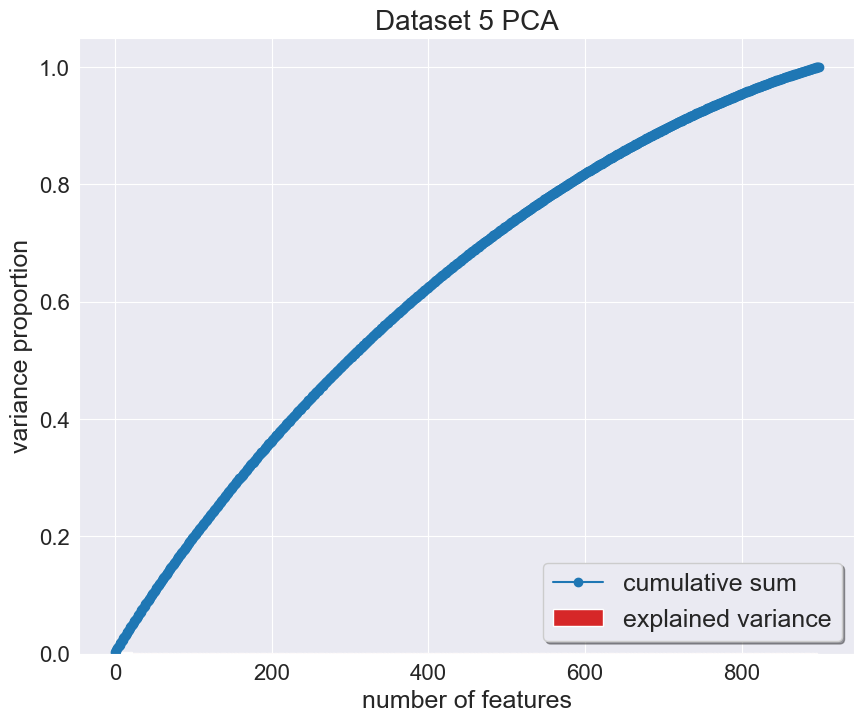

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

i = 5

pca = PCA()

pca.fit(StandardScaler().fit_transform(X_trains[i]))


n_features = np.arange(min(X_trains[i].shape[1], X_trains[i].shape[0]))
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(10, 8))

plt.bar(n_features, explained_variance, label='explained variance',
       color=sns.color_palette()[3])
plt.plot(n_features, np.cumsum(explained_variance), marker='o', label='cumulative sum',
       color=sns.color_palette()[0])

plt.xlabel("number of features", fontsize=18)
plt.ylabel("variance proportion", fontsize=18)
plt.title(f"Dataset {i} PCA", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(bottom=0, top=1.05)

plt.legend(shadow = True, fontsize=18, loc='lower right')

plt.show()

In [57]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

Res_ACC = namedtuple("Results", ("ones_prop", "train_acc", "test_acc", "var_smoothing"))
Res_AUC = namedtuple("Results", ("ones_prop", "train_AUC", "test_AUC", "var_smoothing"))
Res_ASY1 = namedtuple("Results", ("ones_prop", "train_ASY1", "test_ASY1", "var_smoothing"))
Res_ASY2 = namedtuple("Results", ("ones_prop", "train_ASY2", "test_ASY2", "var_smoothing"))

# results_PCA_naive_bayes_ACC = {}
# results_PCA_naive_bayes_AUC = {}
# results_PCA_naive_bayes_ASY1 = {}
# results_PCA_naive_bayes_ASY2 = {}

idxs_to_use_PCA = [4, 5, 6, 8, 9, 10, 13]

var_smoothings = np.logspace(start=-5, stop=2, num=1000)

for i in tqdm(idxs_to_use_PCA, colour="#229922"):
    X_train, X_test, y_train, y_test = X_trains[i], X_tests[i], y_trains[i], y_tests[i]
    
    for var_smoothing in tqdm(var_smoothings, colour="#222299"):

        if i == 4:
            n_components = 14
        elif i == 6:
            n_components = 1
        elif i == 13:
            n_components = 6
        else:
            n_components = None
        
        clf = Pipeline([
                    ('scaler', StandardScaler()),
                    ('reducer', PCA(n_components=n_components)),
                    ('clf', naive_bayes.GaussianNB(var_smoothing=var_smoothing))]).fit(X_train, y_train)
        
        y_pred_train = clf.predict_proba(X_train)[:, 1]
        y_pred_test = clf.predict_proba(X_test)[:, 1]

        ones_prop = (y_train.sum() + y_test.sum()) / (len(y_train)+len(y_test))
        test_acc = sum(np.round(y_pred_test, 0) == y_test) / len(y_test)
        train_acc = sum(np.round(y_pred_train, 0) == y_train) / len(y_train)
        try:
            test_auc = sklearn.metrics.roc_auc_score(y_test, y_pred_test)
        except: test_auc = 0
        try:
            train_auc = sklearn.metrics.roc_auc_score(y_train, y_pred_train)
        except: train_auc = 0
        train_ASY1 = ASY1(y_pred_train, y_train)
        test_ASY1 = ASY1(y_pred_test, y_test)
        train_ASY2 = ASY2(y_pred_train, y_train)
        test_ASY2 = ASY2(y_pred_test, y_test)
        
    
        results_ACC = Res_ACC(ones_prop, train_acc, test_acc, var_smoothing)
        results_AUC = Res_AUC(ones_prop, train_auc, test_auc, var_smoothing)
        results_ASY1 = Res_ASY1(ones_prop, train_ASY1, test_ASY1, var_smoothing)
        results_ASY2 = Res_ASY2(ones_prop, train_ASY2, test_ASY2, var_smoothing)
        
        prev_res = results_PCA_naive_bayes_ACC.get(i)
        if prev_res is None or prev_res.test_acc < results_ACC.test_acc:
            results_PCA_naive_bayes_ACC.update({i:results_ACC})    

        prev_res_auc = results_PCA_naive_bayes_AUC.get(i)
        if prev_res_auc is None or prev_res_auc.test_AUC < results_AUC.test_AUC:
            results_PCA_naive_bayes_AUC.update({i:results_AUC}) 

        prev_res_ASY1 = results_PCA_naive_bayes_ASY1.get(i)
        if prev_res_ASY1 is None or prev_res_ASY1.test_ASY1 > results_ASY1.test_ASY1:
            results_PCA_naive_bayes_ASY1.update({i:results_ASY1}) 

        prev_res_ASY2 = results_PCA_naive_bayes_ASY2.get(i)
        if prev_res_ASY2 is None or prev_res_ASY2.test_ASY2 > results_ASY2.test_ASY2:
            results_PCA_naive_bayes_ASY2.update({i:results_ASY2}) 

    print(f"Dataset {i}\n  Var_smoothing: {results_PCA_naive_bayes_ACC[i].var_smoothing}\n  Ones proportion: {results_PCA_naive_bayes_ACC[i].ones_prop}\n  Train acc: {results_PCA_naive_bayes_ACC[i].train_acc}\n  Test acc: {results_PCA_naive_bayes_ACC[i].test_acc}\n")
    print(f"\n  Var_smoothing: {results_PCA_naive_bayes_AUC[i].var_smoothing}\n  Ones proportion: {results_PCA_naive_bayes_AUC[i].ones_prop}\n  Train AUC: {results_PCA_naive_bayes_AUC[i].train_AUC}\n  Test AUC: {results_PCA_naive_bayes_AUC[i].test_AUC}\n")
    print(f"\n  Var_smoothing: {results_PCA_naive_bayes_ASY1[i].var_smoothing}\n  Ones proportion: {results_PCA_naive_bayes_ASY1[i].ones_prop}\n  Train ASY1: {results_PCA_naive_bayes_ASY1[i].train_ASY1}\n  Test ASY1: {results_PCA_naive_bayes_ASY1[i].test_ASY1}\n")
    print(f"\n  Var_smoothing: {results_PCA_naive_bayes_ASY2[i].var_smoothing}\n  Ones proportion: {results_PCA_naive_bayes_ASY2[i].ones_prop}\n  Train ASY2: {results_PCA_naive_bayes_ASY2[i].train_ASY2}\n  Test ASY2: {results_PCA_naive_bayes_ASY2[i].test_ASY2}\n")

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Dataset 13
  Var_smoothing: 0.0001
  Ones proportion: 0.17917917917917917
  Train acc: 0.8209121245828699
  Test acc: 0.82


  Var_smoothing: 1e-05
  Ones proportion: 0.17917917917917917
  Train AUC: 0.5610513558551734
  Test AUC: 0.5840108401084011


  Var_smoothing: 0.0001
  Ones proportion: 0.17917917917917917
  Train ASY1: -7.209121245828698
  Test ASY1: -7.2


  Var_smoothing: 0.0001
  Ones proportion: 0.17917917917917917
  Train ASY2: -0.46273637374860954
  Test ASY2: -0.46



In [73]:
Res_ACC = namedtuple("Results", ("ones_prop", "train_acc", "test_acc", "reg_param"))
Res_AUC = namedtuple("Results", ("ones_prop", "train_AUC", "test_AUC", "reg_param"))
Res_ASY1 = namedtuple("Results", ("ones_prop", "train_ASY1", "test_ASY1", "reg_param"))
Res_ASY2 = namedtuple("Results", ("ones_prop", "train_ASY2", "test_ASY2", "reg_param"))

# results_PCA_QDA_ACC = {}
# results_PCA_QDA_AUC = {}
# results_PCA_QDA_ASY1 = {}
# results_PCA_QDA_ASY2 = {}

idxs_to_use_PCA = [4, 5, 6, 8, 9, 10, 13]


reg_params = np.logspace(start=-8, stop=0, num=100)

for i in tqdm(idxs_to_use_PCA, colour="#229922"):
    X_train, X_test, y_train, y_test = X_trains[i], X_tests[i], y_trains[i], y_tests[i]
    
    for reg_param in tqdm(reg_params, colour="#222299"):

        if i == 4:
            n_components = 14
        elif i == 6:
            n_components = 5
        elif i == 13:
            n_components = 6
        else:
            n_components = None
        
        clf = Pipeline([
                    ('scaler', StandardScaler()),
                    ('reducer', PCA(n_components=n_components)),
                    ('clf', discriminant_analysis.QuadraticDiscriminantAnalysis(reg_param=reg_param))]).fit(X_train, y_train)
        
        y_pred_train = clf.predict_proba(X_train)[:, 1]
        y_pred_test = clf.predict_proba(X_test)[:, 1]

        ones_prop = (y_train.sum() + y_test.sum()) / (len(y_train)+len(y_test))
        test_acc = sum(np.round(y_pred_test, 0) == y_test) / len(y_test)
        train_acc = sum(np.round(y_pred_train, 0) == y_train) / len(y_train)
        try:
            test_auc = sklearn.metrics.roc_auc_score(y_test, y_pred_test)
        except: test_auc = 0
        try:
            train_auc = sklearn.metrics.roc_auc_score(y_train, y_pred_train)
        except: train_auc = 0
        train_ASY1 = ASY1(y_pred_train, y_train)
        test_ASY1 = ASY1(y_pred_test, y_test)
        train_ASY2 = ASY2(y_pred_train, y_train)
        test_ASY2 = ASY2(y_pred_test, y_test)
        
    
        results_ACC = Res_ACC(ones_prop, train_acc, test_acc, reg_param)
        results_AUC = Res_AUC(ones_prop, train_auc, test_auc, reg_param)
        results_ASY1 = Res_ASY1(ones_prop, train_ASY1, test_ASY1, reg_param)
        results_ASY2 = Res_ASY2(ones_prop, train_ASY2, test_ASY2, reg_param)
        
        prev_res = results_PCA_QDA_ACC.get(i)
        if prev_res is None or prev_res.test_acc < results_ACC.test_acc:
            results_PCA_QDA_ACC.update({i:results_ACC})    

        prev_res_auc = results_PCA_QDA_AUC.get(i)
        if prev_res_auc is None or prev_res_auc.test_AUC < results_AUC.test_AUC:
            results_PCA_QDA_AUC.update({i:results_AUC}) 

        prev_res_ASY1 = results_PCA_QDA_ASY1.get(i)
        if prev_res_ASY1 is None or prev_res_ASY1.test_ASY1 > results_ASY1.test_ASY1:
            results_PCA_QDA_ASY1.update({i:results_ASY1}) 

        prev_res_ASY2 = results_PCA_QDA_ASY2.get(i)
        if prev_res_ASY2 is None or prev_res_ASY2.test_ASY2 > results_ASY2.test_ASY2:
            results_PCA_QDA_ASY2.update({i:results_ASY2}) 

    print(f"Dataset {i}\n  Reg_param: {results_PCA_QDA_ACC[i].reg_param}\n  Ones proportion: {results_PCA_QDA_ACC[i].ones_prop}\n  Train acc: {results_PCA_QDA_ACC[i].train_acc}\n  Test acc: {results_PCA_QDA_ACC[i].test_acc}\n")
    print(f"\n  Reg_param: {results_PCA_QDA_AUC[i].reg_param}\n  Ones proportion: {results_PCA_QDA_AUC[i].ones_prop}\n  Train AUC: {results_QDA_AUC[i].train_AUC}\n  Test AUC: {results_PCA_QDA_AUC[i].test_AUC}\n")
    print(f"\n  Reg_param: {results_PCA_QDA_ASY1[i].reg_param}\n  Ones proportion: {results_PCA_QDA_ASY1[i].ones_prop}\n  Train ASY1: {results_PCA_QDA_ASY1[i].train_ASY1}\n  Test ASY1: {results_PCA_QDA_ASY1[i].test_ASY1}\n")
    print(f"\n  Reg_param: {results_PCA_QDA_ASY2[i].reg_param}\n  Ones proportion: {results_PCA_QDA_ASY2[i].ones_prop}\n  Train ASY2: {results_PCA_QDA_ASY2[i].train_ASY2}\n  Test ASY2: {results_PCA_QDA_ASY2[i].test_ASY2}\n")

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Dataset 4
  Reg_param: 1e-08
  Ones proportion: 0.16416416416416416
  Train acc: 0.8509454949944383
  Test acc: 0.82


  Reg_param: 1.0
  Ones proportion: 0.16416416416416416
  Train AUC: 0.552709000611797
  Test AUC: 0.5334821428571428


  Reg_param: 1e-08
  Ones proportion: 0.16416416416416416
  Train ASY1: -7.218020022246941
  Test ASY1: -7.04


  Reg_param: 1e-08
  Ones proportion: 0.16416416416416416
  Train ASY2: -0.5439377085650723
  Test ASY2: -0.44



  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\Nikita\anaconda3\envs\DL\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nikita\anaconda3\envs\DL\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nikita\anaconda3\envs\DL\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nikita\anaconda3\envs\DL\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nikita\anaconda3\envs\DL\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nikita\anaconda3\envs\DL\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variab

Dataset 5
  Reg_param: 0.0004037017258596558
  Ones proportion: 0.37237237237237236
  Train acc: 0.914349276974416
  Test acc: 0.52


  Reg_param: 0.00048626015800653534
  Ones proportion: 0.37237237237237236
  Train AUC: 1.0
  Test AUC: 0.5512655512655513


  Reg_param: 1e-08
  Ones proportion: 0.37237237237237236
  Train ASY1: -5.60622914349277
  Test ASY1: 0.46


  Reg_param: 0.0004037017258596558
  Ones proportion: 0.37237237237237236
  Train ASY2: -0.657397107897664
  Test ASY2: 0.79



  0%|          | 0/100 [00:00<?, ?it/s]

Dataset 6
  Reg_param: 0.0007054802310718645
  Ones proportion: 0.4854854854854855
  Train acc: 0.6840934371523916
  Test acc: 0.74


  Reg_param: 3.5938136638046256e-05
  Ones proportion: 0.4854854854854855
  Train AUC: 0.6753026730338637
  Test AUC: 0.8227290916366546


  Reg_param: 2.477076355991714e-05
  Ones proportion: 0.4854854854854855
  Train ASY1: -1.7241379310344827
  Test ASY1: -2.45


  Reg_param: 0.0007054802310718645
  Ones proportion: 0.4854854854854855
  Train ASY2: 0.10344827586206896
  Test ASY2: -0.1



  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\Nikita\anaconda3\envs\DL\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nikita\anaconda3\envs\DL\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nikita\anaconda3\envs\DL\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nikita\anaconda3\envs\DL\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nikita\anaconda3\envs\DL\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nikita\anaconda3\envs\DL\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variab

Dataset 8
  Reg_param: 9.3260334688322e-08
  Ones proportion: 0.2022022022022022
  Train acc: 0.7563959955506118
  Test acc: 0.67


  Reg_param: 0.0012328467394420685
  Ones proportion: 0.2022022022022022
  Train AUC: 0.0
  Test AUC: 0.6062500000000001


  Reg_param: 1.0
  Ones proportion: 0.2022022022022022
  Train ASY1: -5.686318131256952
  Test ASY1: -3.98


  Reg_param: 1.0
  Ones proportion: 0.2022022022022022
  Train ASY2: -0.30700778642936594
  Test ASY2: 0.16



C:\Users\Nikita\anaconda3\envs\DL\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\Nikita\anaconda3\envs\DL\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nikita\anaconda3\envs\DL\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nikita\anaconda3\envs\DL\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nikita\anaconda3\envs\DL\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nikita\anaconda3\envs\DL\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nikita\anaconda3\envs\DL\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variab

Dataset 9
  Reg_param: 1.0
  Ones proportion: 0.18018018018018017
  Train acc: 0.8164627363737486
  Test acc: 0.76


  Reg_param: 1.0
  Ones proportion: 0.18018018018018017
  Train AUC: 0.0
  Test AUC: 0.6504065040650406


  Reg_param: 1.0
  Ones proportion: 0.18018018018018017
  Train ASY1: -5.889877641824249
  Test ASY1: -5.61


  Reg_param: 1.0
  Ones proportion: 0.18018018018018017
  Train ASY2: -0.37263626251390436
  Test ASY2: -0.19



C:\Users\Nikita\anaconda3\envs\DL\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\Nikita\anaconda3\envs\DL\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nikita\anaconda3\envs\DL\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nikita\anaconda3\envs\DL\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nikita\anaconda3\envs\DL\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nikita\anaconda3\envs\DL\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\Nikita\anaconda3\envs\DL\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variab

Dataset 10
  Reg_param: 0.22570197196339215
  Ones proportion: 0.3893893893893894
  Train acc: 0.8075639599555061
  Test acc: 0.59


  Reg_param: 1.0
  Ones proportion: 0.3893893893893894
  Train AUC: 0.0
  Test AUC: 0.5704077343421606


  Reg_param: 0.22570197196339215
  Ones proportion: 0.3893893893893894
  Train ASY1: -4.887652947719689
  Test ASY1: -3.38


  Reg_param: 0.22570197196339215
  Ones proportion: 0.3893893893893894
  Train ASY2: -0.3982202447163515
  Test ASY2: 0.33



  0%|          | 0/100 [00:00<?, ?it/s]

Dataset 13
  Reg_param: 1e-08
  Ones proportion: 0.17917917917917917
  Train acc: 0.8220244716351501
  Test acc: 0.82


  Reg_param: 0.27185882427329455
  Ones proportion: 0.17917917917917917
  Train AUC: 0.676934471208066
  Test AUC: 0.570460704607046


  Reg_param: 0.6892612104349709
  Ones proportion: 0.17917917917917917
  Train ASY1: -7.209121245828698
  Test ASY1: -7.2


  Reg_param: 0.6892612104349709
  Ones proportion: 0.17917917917917917
  Train ASY2: -0.46273637374860954
  Test ASY2: -0.46



In [72]:
Res_ACC = namedtuple("Results", ("ones_prop", "train_acc", "test_acc", "tol"))
Res_AUC = namedtuple("Results", ("ones_prop", "train_AUC", "test_AUC", "tol"))
Res_ASY1 = namedtuple("Results", ("ones_prop", "train_ASY1", "test_ASY1", "tol"))
Res_ASY2 = namedtuple("Results", ("ones_prop", "train_ASY2", "test_ASY2", "tol"))

# results_PCA_LDA_ACC = {}
# results_PCA_LDA_AUC = {}
# results_PCA_LDA_ASY1 = {}
# results_PCA_LDA_ASY2 = {}

# idxs_to_use_PCA = [4, 5, 6, 8, 9, 10, 13]
idxs_to_use_PCA = [8, 9, 10]

tols = np.logspace(start=-8, stop=0, num=100)

for i in tqdm(idxs_to_use_PCA, colour="#229922"):
    X_train, X_test, y_train, y_test = X_trains[i], X_tests[i], y_trains[i], y_tests[i]
    
    for tol in tqdm(tols, colour="#222299"):

        if i == 4:
            n_components = 14
        elif i == 6:
            n_components = 5
        elif i == 13:
            n_components = 6
        else:
            n_components = 20
        
        clf = Pipeline([
                    ('scaler', StandardScaler()),
                    ('reducer', PCA(n_components=n_components)),
                    ('clf', discriminant_analysis.LinearDiscriminantAnalysis(tol=tol))]).fit(X_train, y_train)
        
        y_pred_train = clf.predict_proba(X_train)[:, 1]
        y_pred_test = clf.predict_proba(X_test)[:, 1]

        ones_prop = (y_train.sum() + y_test.sum()) / (len(y_train)+len(y_test))
        test_acc = sum(np.round(y_pred_test, 0) == y_test) / len(y_test)
        train_acc = sum(np.round(y_pred_train, 0) == y_train) / len(y_train)
        try:
            test_auc = sklearn.metrics.roc_auc_score(y_test, y_pred_test)
        except: test_auc = 0
        try:
            train_auc = sklearn.metrics.roc_auc_score(y_train, y_pred_train)
        except: train_auc = 0
        train_ASY1 = ASY1(y_pred_train, y_train)
        test_ASY1 = ASY1(y_pred_test, y_test)
        train_ASY2 = ASY2(y_pred_train, y_train)
        test_ASY2 = ASY2(y_pred_test, y_test)
        
    
        results_ACC = Res_ACC(ones_prop, train_acc, test_acc, tol)
        results_AUC = Res_AUC(ones_prop, train_auc, test_auc, tol)
        results_ASY1 = Res_ASY1(ones_prop, train_ASY1, test_ASY1, tol)
        results_ASY2 = Res_ASY2(ones_prop, train_ASY2, test_ASY2, tol)
        
        prev_res = results_PCA_LDA_ACC.get(i)
        if prev_res is None or prev_res.test_acc < results_ACC.test_acc:
            results_PCA_LDA_ACC.update({i:results_ACC})    

        prev_res_auc = results_PCA_LDA_AUC.get(i)
        if prev_res_auc is None or prev_res_auc.test_AUC < results_AUC.test_AUC:
            results_PCA_LDA_AUC.update({i:results_AUC}) 

        prev_res_ASY1 = results_PCA_LDA_ASY1.get(i)
        if prev_res_ASY1 is None or prev_res_ASY1.test_ASY1 > results_ASY1.test_ASY1:
            results_PCA_LDA_ASY1.update({i:results_ASY1}) 

        prev_res_ASY2 = results_PCA_LDA_ASY2.get(i)
        if prev_res_ASY2 is None or prev_res_ASY2.test_ASY2 > results_ASY2.test_ASY2:
            results_PCA_LDA_ASY2.update({i:results_ASY2}) 

    print(f"Dataset {i}\n  Tol: {results_PCA_LDA_ACC[i].tol}\n  Ones proportion: {results_PCA_LDA_ACC[i].ones_prop}\n  Train acc: {results_PCA_LDA_ACC[i].train_acc}\n  Test acc: {results_PCA_LDA_ACC[i].test_acc}\n")
    print(f"\n  Tol: {results_PCA_LDA_AUC[i].tol}\n  Ones proportion: {results_PCA_LDA_AUC[i].ones_prop}\n  Train AUC: {results_PCA_LDA_AUC[i].train_AUC}\n  Test AUC: {results_PCA_LDA_AUC[i].test_AUC}\n")
    print(f"\n  Tol: {results_PCA_LDA_ASY1[i].tol}\n  Ones proportion: {results_PCA_LDA_ASY1[i].ones_prop}\n  Train ASY1: {results_PCA_LDA_ASY1[i].train_ASY1}\n  Test ASY1: {results_PCA_LDA_ASY1[i].test_ASY1}\n")
    print(f"\n  Tol: {results_PCA_LDA_ASY2[i].tol}\n  Ones proportion: {results_PCA_LDA_ASY2[i].ones_prop}\n  Train ASY2: {results_PCA_LDA_ASY2[i].train_ASY2}\n  Test ASY2: {results_PCA_LDA_ASY2[i].test_ASY2}\n")

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Dataset 8
  Tol: 0.0005857020818056673
  Ones proportion: 0.2022022022022022
  Train acc: 0.8153503893214683
  Test acc: 0.81


  Tol: 0.024201282647943835
  Ones proportion: 0.2022022022022022
  Train AUC: 0.6038974972029365
  Test AUC: 0.6749999999999999


  Tol: 1.0
  Ones proportion: 0.2022022022022022
  Train ASY1: -6.975528364849833
  Test ASY1: -7.0


  Tol: 0.0005857020818056673
  Ones proportion: 0.2022022022022022
  Train ASY2: -0.4271412680756396
  Test ASY2: -0.41



  0%|          | 0/100 [00:00<?, ?it/s]

Dataset 9
  Tol: 1.747528400007683e-08
  Ones proportion: 0.18018018018018017
  Train acc: 0.8476084538375973
  Test acc: 0.83


  Tol: 0.0014849682622544665
  Ones proportion: 0.18018018018018017
  Train AUC: 0.7556828651356016
  Test AUC: 0.7330623306233063


  Tol: 1.747528400007683e-08
  Ones proportion: 0.18018018018018017
  Train ASY1: -7.112347052280311
  Test ASY1: -7.21


  Tol: 1.747528400007683e-08
  Ones proportion: 0.18018018018018017
  Train ASY2: -0.5361512791991101
  Test ASY2: -0.49



  0%|          | 0/100 [00:00<?, ?it/s]

Dataset 10
  Tol: 1.4174741629268077e-05
  Ones proportion: 0.3893893893893894
  Train acc: 0.6718576195773082
  Test acc: 0.64


  Tol: 1.7073526474706923e-05
  Ones proportion: 0.3893893893893894
  Train AUC: 0.5731303669008587
  Test AUC: 0.6284153005464481


  Tol: 1.8307382802953698e-06
  Ones proportion: 0.3893893893893894
  Train ASY1: -4.816462736373748
  Test ASY1: -5.12


  Tol: 1.8307382802953698e-06
  Ones proportion: 0.3893893893893894
  Train ASY2: 0.14905450500556172
  Test ASY2: 0.11



In [77]:
best_clf_ACC = []
best_clf_AUC = []
best_clf_ASY1 = []
best_clf_ASY2 = []

best_ACC = []
best_AUC = []
best_ASY1 = []
best_ASY2 = []

clfs = ["naive_bayes", "QDA", "LDA", "PCA_naive_bayes", "PCA_QDA", "PCA_LDA"]

CLF_PARAM = namedtuple("CL_with_Param", ("clf", "param"))

res_accs = [results_naive_bayes, results_QDA_ACC, results_LDA_ACC, 
            results_PCA_naive_bayes_ACC, results_PCA_QDA_ACC, results_PCA_LDA_ACC]
res_aucs = [results_naive_bayes_AUC, results_QDA_AUC, results_LDA_AUC,
            results_PCA_naive_bayes_AUC, results_PCA_QDA_AUC, results_PCA_LDA_AUC]
res_asy1s = [results_naive_bayes_ASY1, results_QDA_ASY1, results_LDA_ASY1,
             results_PCA_naive_bayes_ASY1, results_PCA_QDA_ASY1, results_PCA_LDA_ASY1]
res_asy2s = [results_naive_bayes_ASY2, results_QDA_ASY2, results_LDA_ASY2,
             results_PCA_naive_bayes_ASY2, results_PCA_QDA_ASY2, results_PCA_LDA_ASY2]

for i in tqdm(range(1, 15, 1), colour="#229922", leave=False):
    X, y = datasets[i]

    accs_best_idx = np.argmax([res[i].test_acc if res.get(i) is not None else -1000 for res in res_accs])
    aucs_best_idx = np.argmax([res[i].test_AUC if res.get(i) is not None else -1000 for res in res_aucs])
    asy1s_best_idx = np.argmin([res[i].test_ASY1 if res.get(i) is not None else 1000000 for res in res_asy1s])
    asy2s_best_idx = np.argmin([res[i].test_ASY2 if res.get(i) is not None else 1000000 for res in res_asy2s])

    
    best_clf_ACC.append(CLF_PARAM(clfs[accs_best_idx], res_accs[accs_best_idx][i][-1]))
    best_clf_AUC.append(CLF_PARAM(clfs[aucs_best_idx], res_aucs[aucs_best_idx][i][-1]))
    best_clf_ASY1.append(CLF_PARAM(clfs[asy1s_best_idx], res_asy1s[asy1s_best_idx][i][-1]))
    best_clf_ASY2.append(CLF_PARAM(clfs[asy2s_best_idx], res_asy2s[asy2s_best_idx][i][-1]))

    best_ACC.append(res_accs[accs_best_idx][i].test_acc)
    best_AUC.append(res_aucs[aucs_best_idx][i].test_AUC)
    best_ASY1.append(res_asy1s[asy1s_best_idx][i].test_ASY1)
    best_ASY2.append(res_asy2s[asy2s_best_idx][i].test_ASY2)


Baseline = [round(max(results_LDA_ACC[i].ones_prop, 1-results_LDA_ACC[i].ones_prop), 3) for i in range(1,15,1)]
indexes = [f"Dataset {i}" for i in range(1,15)]
best_so_far_df = pd.DataFrame(data={"Baseline": Baseline, "Best_ACC": best_ACC, "Best_ACC_model": best_clf_ACC,
                                    "Best_AUC": best_AUC, "Best_AUC_model": best_clf_AUC, "Best_ASY1": best_ASY1, 
                                    "Best_ASY1_model": best_clf_ASY1, "Best_ASY2": Test_ASY2, 
                                    "Best_ASY2_model": best_clf_ASY2}, index=np.arange(1,15,1))

best_so_far_df

  0%|          | 0/14 [00:00<?, ?it/s]

,Baseline,Best_ACC,Best_ACC_model,Best_AUC,Best_AUC_model,Best_ASY1,Best_ASY1_model,Best_ASY2,Best_ASY2_model
1,0.510,0.6100,"(naive_bayes, 1.1273325637104872)",0.590636,"(QDA, 1.0)",-0.7400,"(naive_bayes, 0.24739641008868116)",0.560,"(naive_bayes, 0.5281079711934331)"
2,0.531,0.6900,"(LDA, 1e-08)",0.734645,"(naive_bayes, 1e-05)",-4.3300,"(naive_bayes, 8.748668120479914)",0.080,"(naive_bayes, 4.165044248545185)"
3,0.513,0.6500,"(QDA, 2.310129700083158e-06)",0.703481,"(LDA, 1e-08)",-4.1000,"(naive_bayes, 3.4319071974590427)",0.290,"(QDA, 2.310129700083158e-06)"
4,0.836,0.8400,"(naive_bayes, 0.4422273980505897)",0.578869,"(QDA, 1.0)",-7.4000,"(naive_bayes, 0.8431909292866251)",-0.520,"(naive_bayes, 0.8431909292866251)"
5,0.628,0.6600,"(PCA_naive_bayes, 0.10424040070215569)",0.608323,"(PCA_naive_bayes, 0.0006391624053344006)",-5.3100,"(PCA_naive_bayes, 0.9034660211810535)",0.110,"(PCA_naive_bayes, 0.9034660211810535)"
6,0.515,0.7500,"(PCA_naive_bayes, 1.623382431612278e-05)",0.822729,"(PCA_QDA, 3.5938136638046256e-05)",-4.2700,"(PCA_naive_bayes, 14.398479528760065)",0.010,"(PCA_naive_bayes, 1.623382431612278e-05)"
7,0.868,0.8700,"(naive_bayes, 2.445616683452444)",0.548187,"(naive_bayes, 27.954159990678594)",-7.7000,"(naive_bayes, 2.445616683452444)",-0.610,"(naive_bayes, 2.445616683452444)"
8,0.798,0.8100,"(PCA_LDA, 0.0005857020818056673)",0.709375,"(LDA, 0.39442060594376643)",-7.0000,"(naive_bayes, 2.7380251779278577)",-0.400,"(PCA_LDA, 0.0005857020818056673)"
9,0.820,0.8400,"(naive_bayes, 0.7292272058728313)",0.733062,"(PCA_LDA, 0.0014849682622544665)",-7.2100,"(naive_bayes, 0.9440064789417604)",-0.460,"(naive_bayes, 0.7292272058728313)"
10,0.611,0.6400,"(PCA_LDA, 1.4174741629268077e-05)",0.628415,"(PCA_LDA, 1.7073526474706923e-05)",-5.1200,"(PCA_LDA, 1.8307382802953698e-06)",0.170,"(PCA_LDA, 1.8307382802953698e-06)"
